In [1]:
import sys
import os
import json
import optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from typing import Tuple
from keras.callbacks import ModelCheckpoint, EarlyStopping

## 1. EDA

In [2]:
df_ts = pd.read_csv('imputed_Global.csv')

In [3]:
df_ts.head()

Index  LandAverageTemperature
0  Jan 1750                   3.034
1  Feb 1750                   3.083
2  Mar 1750                   5.626
3  Apr 1750                   8.490
4  May 1750                  11.573

In [4]:
df_ts.isna().sum()

Index                     0
LandAverageTemperature    0
dtype: int64

In [5]:
df_ts.shape

(3192, 2)

In [6]:
df_ts.dtypes

Index                      object
LandAverageTemperature    float64
dtype: object

In [7]:
df_ts['Index'] = pd.to_datetime(df_ts['Index'])
df_ts.sort_values(by='Index', inplace=True)

In [8]:
df_ts.head()

Index  LandAverageTemperature
0 1750-01-01                   3.034
1 1750-02-01                   3.083
2 1750-03-01                   5.626
3 1750-04-01                   8.490
4 1750-05-01                  11.573

In [9]:
df_ts['year'] = df_ts['Index'].dt.year

In [10]:
df_year = df_ts.groupby('year').mean('LandAverageTemperature').reset_index()

<AxesSubplot:xlabel='Index', ylabel='LandAverageTemperature'>

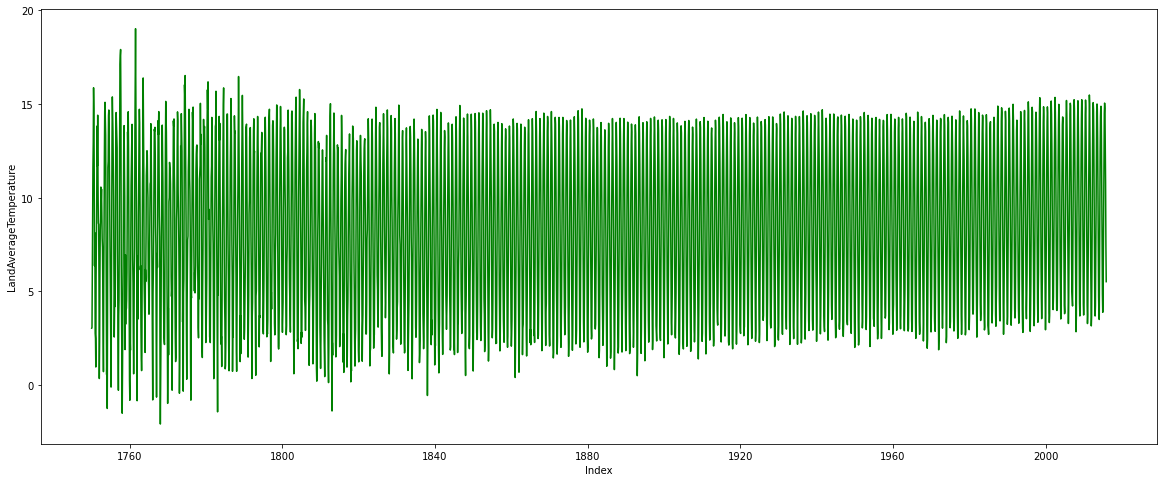

In [11]:
plt.figure(figsize=(20,8))
sns.lineplot(x='Index', y='LandAverageTemperature', color='g', data=df_ts)

Text(0.5, 1.0, 'Global Temperature (2000-2015)')

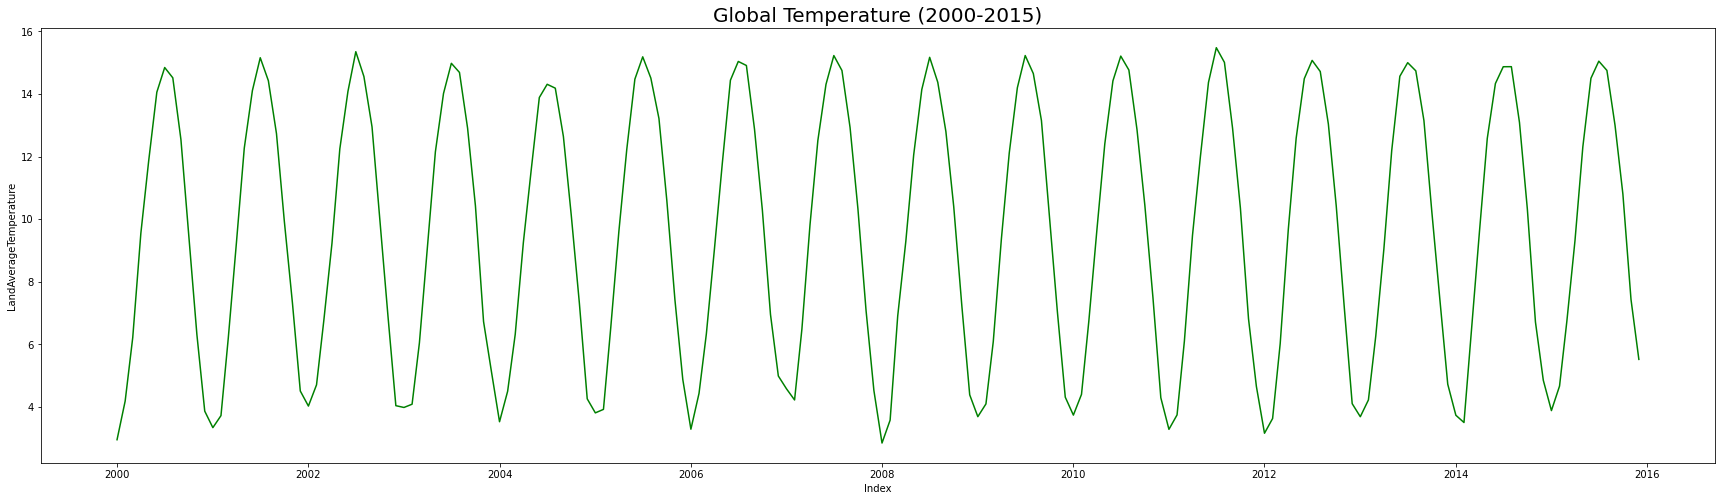

In [12]:
plt.figure(figsize=(30,8))
sns.lineplot(x='Index', y='LandAverageTemperature', color='g', data=df_ts[(df_ts['Index'] >= '2000-01-01') & (df_ts['Index'] <= '2015-12-01')])
plt.title('Global Temperature (2000-2015)', size=20)

Text(0.5, 1.0, 'Yearly Average Global Temperature')

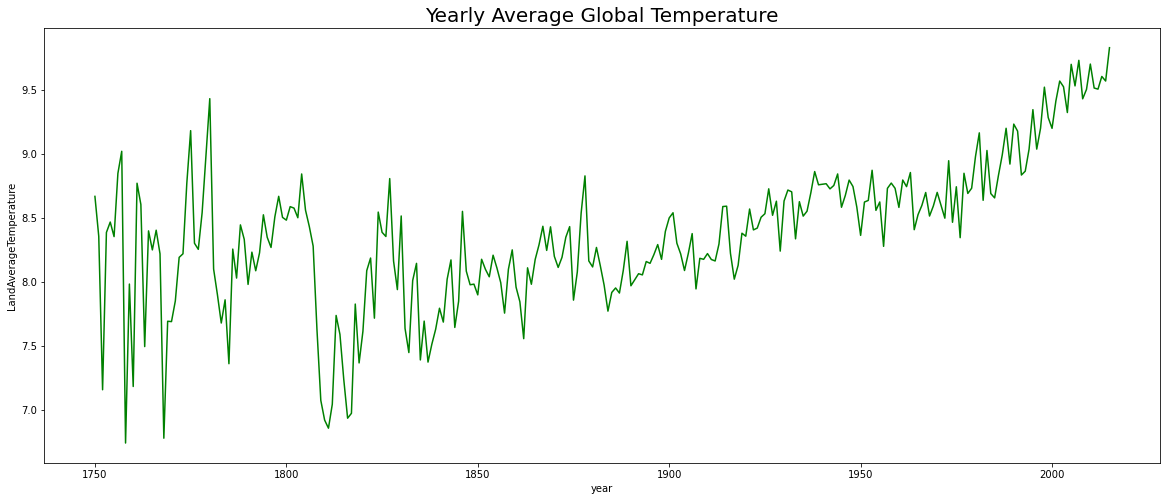

In [13]:
plt.figure(figsize=(20,8))
sns.lineplot(x='year', y='LandAverageTemperature', color='g', data=df_year)
plt.title('Yearly Average Global Temperature', size=20)

In [14]:
df_ts.drop('year', axis=1, inplace=True)

## 2. Helper functions

In [15]:
#train-test split
def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_period: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    x_train = X
    x_test = []

    Y_train = Y
    Y_test = []

    if test_period > 0:
        index = test_period
        x_train = X[: (len(X) - index)]
        x_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return x_train, x_test, Y_train, Y_test

In [16]:
# plot loss function and rmse history
def history(model, title='Train v.s. Validation'):
    plt.figure(figsize = (15, 5) )

    plt.subplot(121)
    plt.plot(model.history['loss'], color='blue', label='train')
    plt.plot(model.history['val_loss'], color='red', label='valid')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')

    plt.subplot(122)
    plt.plot(model.history['root_mean_squared_error'], color = 'blue', label='train')
    plt.plot(model.history['val_root_mean_squared_error'], color='red', label='valid')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

## Fit a single layer LSTM with lag = 3 months

In [76]:
lag = 3
test_period = 36

X_train, X_test, y_train, y_test = create_data_for_NN(df_ts, df_ts.columns[-1], lag, test_period)

In [18]:
model_lstm_3 = Sequential()
model_lstm_3.add(LSTM(units=128, input_shape=X_train.shape[1:]))
model_lstm_3.add(Dense(units=1, activation='relu'))
model_lstm_3.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

In [19]:
checkpointer = ModelCheckpoint(filepath='weights_compare_lstm3.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_lstm3 = model_lstm_3.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000


2022-05-30 18:15:55.656983: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


74/74 [==============================] - 1s 4ms/step - loss: 43.0630 - root_mean_squared_error: 6.5622 - val_loss: 14.9531 - val_root_mean_squared_error: 3.8669
Epoch 2/1000
74/74 [==============================] - 0s 2ms/step - loss: 12.0492 - root_mean_squared_error: 3.4712 - val_loss: 3.4026 - val_root_mean_squared_error: 1.8446
Epoch 3/1000
74/74 [==============================] - 0s 2ms/step - loss: 2.0343 - root_mean_squared_error: 1.4263 - val_loss: 0.2965 - val_root_mean_squared_error: 0.5445
Epoch 4/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.4228 - root_mean_squared_error: 1.1928 - val_loss: 0.5931 - val_root_mean_squared_error: 0.7701
Epoch 5/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.3505 - root_mean_squared_error: 1.1621 - val_loss: 0.3673 - val_root_mean_squared_error: 0.6060
Epoch 6/1000
74/74 [==============================] - 0s 2ms/step - loss: 1.3287 - root_mean_squared_error: 1.1527 - val_loss: 0.2555 - val_root_mean_

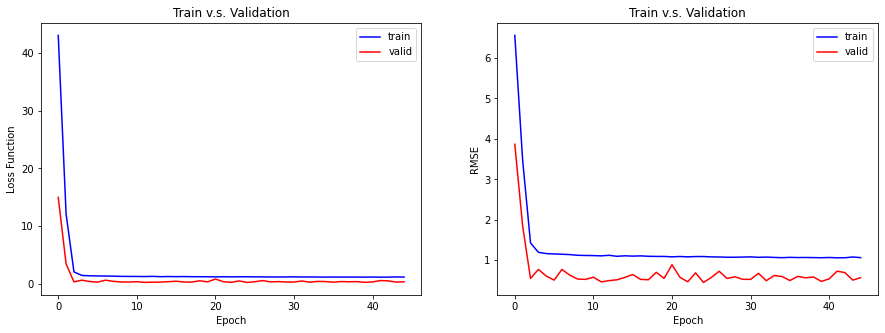

In [20]:
history(history_lstm3)

In [21]:
model_lstm_3.load_weights('weights_compare_lstm3.hdf5')

In [22]:
train_score_lstm_3 = model_lstm_3.evaluate(X_train, y_train, batch_size=32)
print('Train Loss: ', train_score_lstm_3[0])
print('Train RMSE: ', train_score_lstm_3[1])

99/99 [==============================] - 0s 724us/step - loss: 0.9338 - root_mean_squared_error: 0.9663
Train Loss:  0.9337687492370605
Train RMSE:  0.9663171172142029


In [23]:
score_lstm_3 = model_lstm_3.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_lstm_3[0])
print('Test RMSE: ', score_lstm_3[1])

2/2 [==============================] - 0s 1ms/step - loss: 0.4189 - root_mean_squared_error: 0.6473
Test Loss:  0.4189490079879761
Test RMSE:  0.647262692451477


In [24]:
y_pred = model_lstm_3.predict(X_test)

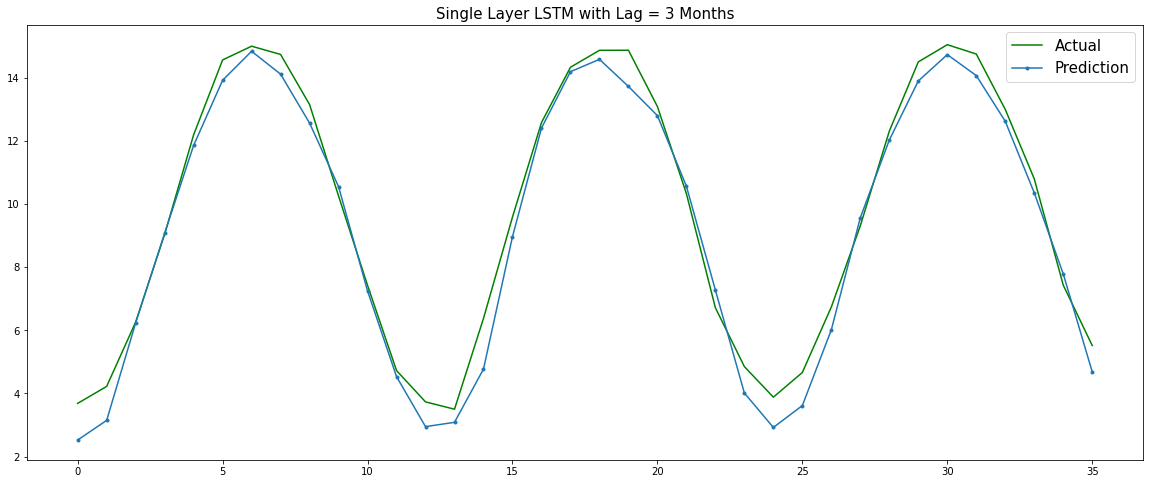

In [25]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Single Layer LSTM with Lag = 3 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a bidirectional LSTM with lag = 3 months

In [77]:
model_blstm_3 = Sequential()
model_blstm_3.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
model_blstm_3.add(Dense(units=1, activation='relu'))
model_blstm_3.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

In [78]:
checkpointer = ModelCheckpoint(filepath='weights_compare_blstm3.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_blstm3 = model_blstm_3.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 1s 6ms/step - loss: 23.1167 - root_mean_squared_error: 4.8080 - val_loss: 8.5765 - val_root_mean_squared_error: 2.9286
Epoch 2/1000
74/74 [==============================] - 0s 3ms/step - loss: 5.9365 - root_mean_squared_error: 2.4365 - val_loss: 1.2775 - val_root_mean_squared_error: 1.1303
Epoch 3/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.8822 - root_mean_squared_error: 1.3719 - val_loss: 0.4250 - val_root_mean_squared_error: 0.6519
Epoch 4/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.4391 - root_mean_squared_error: 1.1996 - val_loss: 0.2724 - val_root_mean_squared_error: 0.5219
Epoch 5/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.3560 - root_mean_squared_error: 1.1645 - val_loss: 0.6936 - val_root_mean_squared_error: 0.8328
Epoch 6/1000
74/74 [==============================] - 0s 3ms/step - loss: 1.3110 - root_mean_squared_error: 1.1450 - val_loss: 0.1962 - val

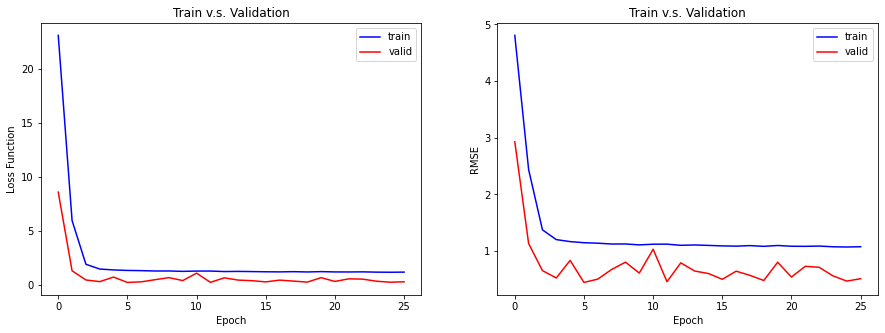

In [79]:
history(history_blstm3)

In [80]:
model_blstm_3.load_weights('weights_compare_blstm3.hdf5')

In [81]:
train_score_blstm_3 = model_blstm_3.evaluate(X_train, y_train, batch_size=32)
print('Train Loss: ', train_score_blstm_3[0])
print('Train RMSE: ', train_score_blstm_3[1])

99/99 [==============================] - 0s 894us/step - loss: 1.0664 - root_mean_squared_error: 1.0326
Train Loss:  1.0663660764694214
Train RMSE:  1.0326499938964844


In [82]:
score_blstm_3 = model_blstm_3.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_blstm_3[0])
print('Test RMSE: ', score_blstm_3[1])

2/2 [==============================] - 0s 1ms/step - loss: 0.2870 - root_mean_squared_error: 0.5357
Test Loss:  0.2870187759399414
Test RMSE:  0.5357413291931152


In [83]:
y_pred = model_blstm_3.predict(X_test)

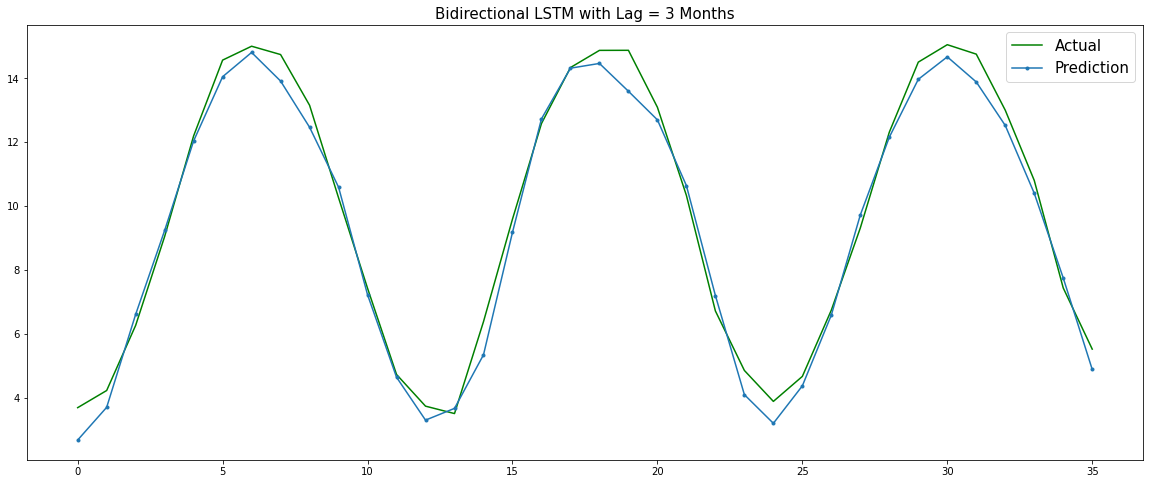

In [84]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Bidirectional LSTM with Lag = 3 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a single layer LSTM with lag = 12 months

In [34]:
lag = 12
test_period = 36

X_train, X_test, y_train, y_test = create_data_for_NN(df_ts, df_ts.columns[-1], lag, test_period)

In [35]:
model_lstm_12 = Sequential()
model_lstm_12.add(LSTM(units=128, input_shape=X_train.shape[1:]))
model_lstm_12.add(Dense(units=1, activation='relu'))
model_lstm_12.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

In [36]:
checkpointer = ModelCheckpoint(filepath='weights_compare_lstm12.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_lstm12 = model_lstm_12.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 1s 7ms/step - loss: 23.8098 - root_mean_squared_error: 4.8795 - val_loss: 14.2485 - val_root_mean_squared_error: 3.7747
Epoch 2/1000
74/74 [==============================] - 0s 5ms/step - loss: 11.2732 - root_mean_squared_error: 3.3576 - val_loss: 3.8589 - val_root_mean_squared_error: 1.9644
Epoch 3/1000
74/74 [==============================] - 0s 5ms/step - loss: 1.7528 - root_mean_squared_error: 1.3239 - val_loss: 0.3827 - val_root_mean_squared_error: 0.6186
Epoch 4/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.9665 - root_mean_squared_error: 0.9831 - val_loss: 0.8036 - val_root_mean_squared_error: 0.8964
Epoch 5/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.9464 - root_mean_squared_error: 0.9728 - val_loss: 0.4765 - val_root_mean_squared_error: 0.6903
Epoch 6/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.9481 - root_mean_squared_error: 0.9737 - val_loss: 0.3489 - v

74/74 [==============================] - 0s 5ms/step - loss: 0.7963 - root_mean_squared_error: 0.8923 - val_loss: 0.2077 - val_root_mean_squared_error: 0.4558
Epoch 49/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.7835 - root_mean_squared_error: 0.8852 - val_loss: 0.3469 - val_root_mean_squared_error: 0.5889
Epoch 50/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.7950 - root_mean_squared_error: 0.8917 - val_loss: 0.3739 - val_root_mean_squared_error: 0.6115
Epoch 51/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.7870 - root_mean_squared_error: 0.8871 - val_loss: 0.2752 - val_root_mean_squared_error: 0.5246
Epoch 52/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.7824 - root_mean_squared_error: 0.8845 - val_loss: 0.3259 - val_root_mean_squared_error: 0.5709
Epoch 53/1000
74/74 [==============================] - 0s 5ms/step - loss: 0.7976 - root_mean_squared_error: 0.8931 - val_loss: 0.4502 - val_root_mea

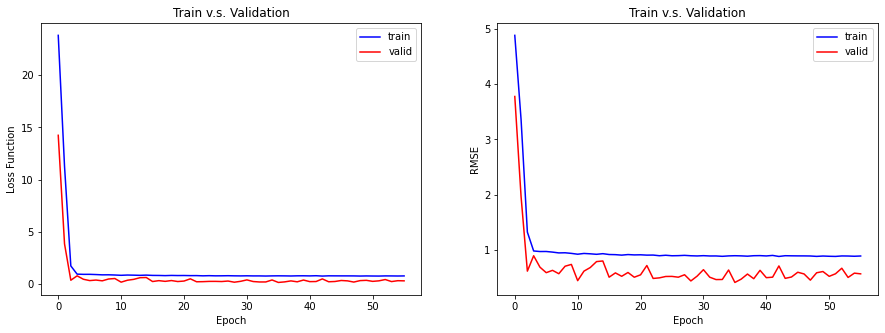

In [37]:
history(history_lstm12)

In [38]:
model_lstm_12.load_weights('weights_compare_lstm12.hdf5')
train_score_lstm_12 = model_lstm_12.evaluate(X_train, y_train, batch_size=32)
print('Train Loss: ', train_score_lstm_12[0])
print('Train RMSE: ', train_score_lstm_12[1])

99/99 [==============================] - 0s 2ms/step - loss: 0.6788 - root_mean_squared_error: 0.8239
Train Loss:  0.6788026690483093
Train RMSE:  0.8238947987556458


In [39]:
score_lstm_12 = model_lstm_12.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_lstm_12[0])
print('Test RMSE: ', score_lstm_12[1])

2/2 [==============================] - 0s 1ms/step - loss: 0.3935 - root_mean_squared_error: 0.6273
Test Loss:  0.39346787333488464
Test RMSE:  0.6272701621055603


In [40]:
y_pred = model_lstm_12.predict(X_test)

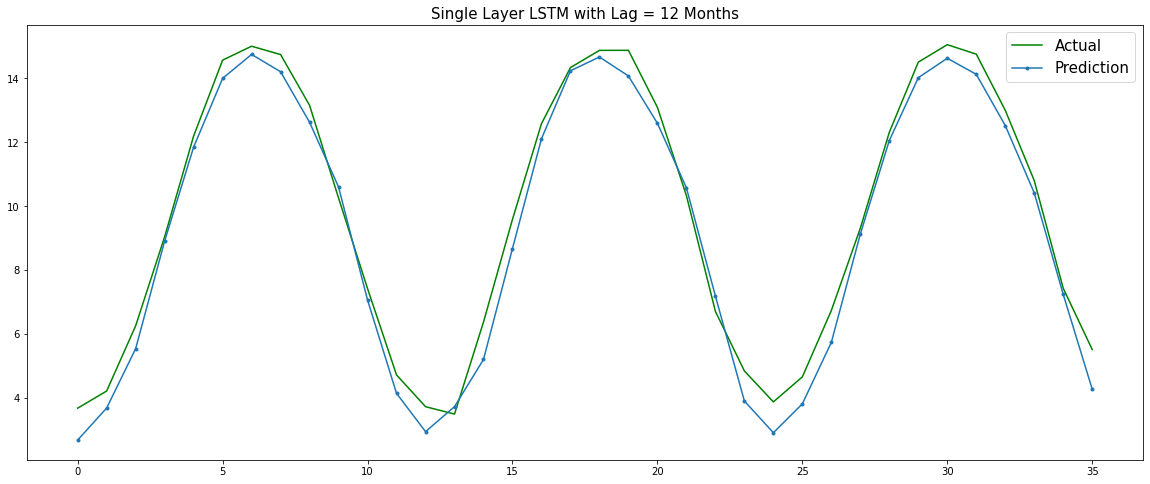

In [41]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Single Layer LSTM with Lag = 12 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a bidirectional LSTM with lag = 12 months

In [42]:
model_blstm_12 = Sequential()
model_blstm_12.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
model_blstm_12.add(Dense(units=1, activation='relu'))
model_blstm_12.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

In [43]:
checkpointer = ModelCheckpoint(filepath='weights_compare_blstm12.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_blstm12 = model_blstm_12.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 2s 10ms/step - loss: 18.2365 - root_mean_squared_error: 4.2704 - val_loss: 2.6260 - val_root_mean_squared_error: 1.6205
Epoch 2/1000
74/74 [==============================] - 0s 7ms/step - loss: 1.1915 - root_mean_squared_error: 1.0915 - val_loss: 0.3320 - val_root_mean_squared_error: 0.5762
Epoch 3/1000
74/74 [==============================] - 1s 7ms/step - loss: 0.8936 - root_mean_squared_error: 0.9453 - val_loss: 0.3095 - val_root_mean_squared_error: 0.5563
Epoch 4/1000
74/74 [==============================] - 1s 8ms/step - loss: 0.8838 - root_mean_squared_error: 0.9401 - val_loss: 0.2928 - val_root_mean_squared_error: 0.5411
Epoch 5/1000
74/74 [==============================] - 1s 8ms/step - loss: 0.8917 - root_mean_squared_error: 0.9443 - val_loss: 0.2166 - val_root_mean_squared_error: 0.4654
Epoch 6/1000
74/74 [==============================] - 1s 8ms/step - loss: 0.8566 - root_mean_squared_error: 0.9255 - val_loss: 0.1867 - va

74/74 [==============================] - 1s 13ms/step - loss: 0.7859 - root_mean_squared_error: 0.8865 - val_loss: 0.2870 - val_root_mean_squared_error: 0.5358


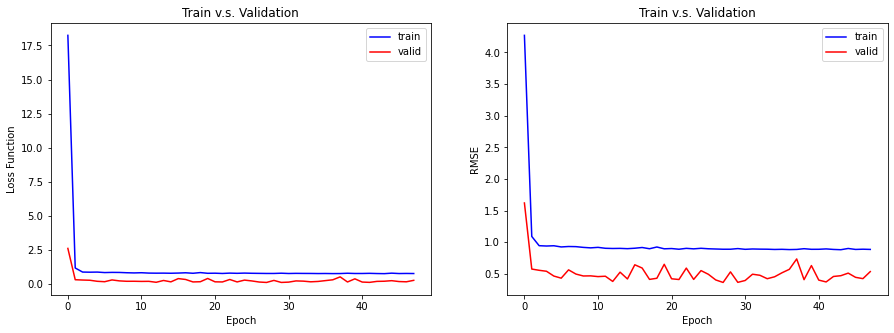

In [44]:
history(history_blstm12)

In [45]:
model_blstm_12.load_weights('weights_compare_blstm12.hdf5')
train_score_blstm_12 = model_blstm_12.evaluate(X_train, y_train, batch_size=32)
print('Train Loss: ', train_score_blstm_12[0])
print('Train RMSE: ', train_score_blstm_12[1])

99/99 [==============================] - 1s 6ms/step - loss: 0.6466 - root_mean_squared_error: 0.8041
Train Loss:  0.646571934223175
Train RMSE:  0.8040969967842102


In [46]:
score_blstm_12 = model_blstm_12.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_blstm_12[0])
print('Test RMSE: ', score_blstm_12[1])

2/2 [==============================] - 0s 1ms/step - loss: 0.2157 - root_mean_squared_error: 0.4644
Test Loss:  0.21567296981811523
Test RMSE:  0.4644060432910919


In [47]:
y_pred = model_blstm_12.predict(X_test)

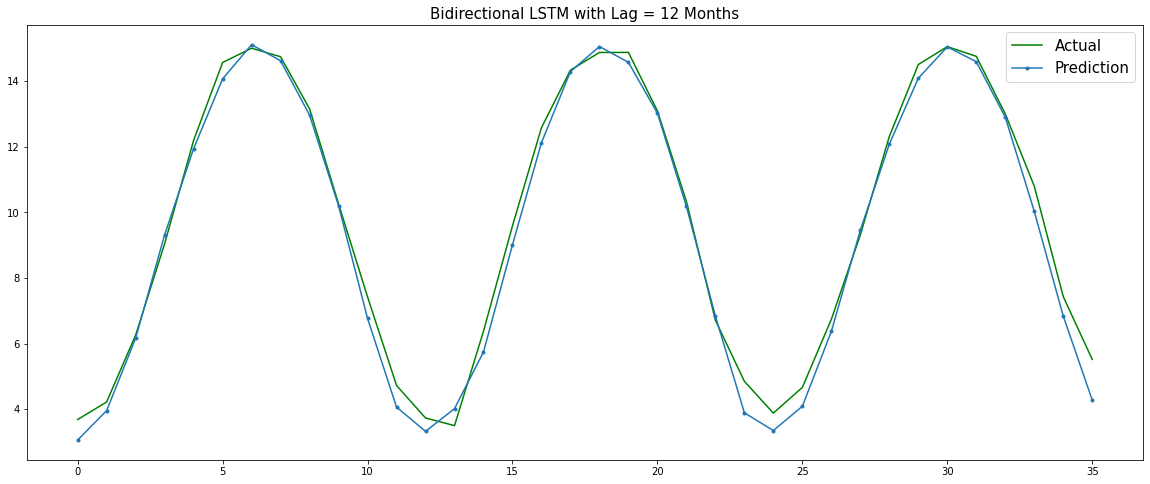

In [48]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Bidirectional LSTM with Lag = 12 Months', size=15)
plt.legend(fontsize=15)
plt.show()

## Fit a bidirectional LSTM with lag = 24 months

In [85]:
lag = 24
test_period = 36

X_train, X_test, y_train, y_test = create_data_for_NN(df_ts, df_ts.columns[-1], lag, test_period)

In [86]:
model_blstm_24 = Sequential()
model_blstm_24.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
model_blstm_24.add(Dense(units=1, activation='relu'))
model_blstm_24.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

In [87]:
checkpointer = ModelCheckpoint(filepath='weights_compare_blstm24.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history_blstm24 = model_blstm_24.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                 callbacks=[checkpointer,checkimprovement])

Epoch 1/1000
74/74 [==============================] - 3s 19ms/step - loss: 17.3550 - root_mean_squared_error: 4.1659 - val_loss: 1.9603 - val_root_mean_squared_error: 1.4001
Epoch 2/1000
74/74 [==============================] - 1s 16ms/step - loss: 1.1368 - root_mean_squared_error: 1.0662 - val_loss: 0.2648 - val_root_mean_squared_error: 0.5146
Epoch 3/1000
74/74 [==============================] - 1s 17ms/step - loss: 0.9683 - root_mean_squared_error: 0.9840 - val_loss: 0.5440 - val_root_mean_squared_error: 0.7376
Epoch 4/1000
74/74 [==============================] - 1s 17ms/step - loss: 0.9225 - root_mean_squared_error: 0.9604 - val_loss: 0.3014 - val_root_mean_squared_error: 0.5490
Epoch 5/1000
74/74 [==============================] - 1s 18ms/step - loss: 0.8929 - root_mean_squared_error: 0.9450 - val_loss: 0.1489 - val_root_mean_squared_error: 0.3859
Epoch 6/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.8934 - root_mean_squared_error: 0.9452 - val_loss: 0.2050

74/74 [==============================] - 1s 17ms/step - loss: 0.8012 - root_mean_squared_error: 0.8951 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801
Epoch 49/1000
74/74 [==============================] - 1s 20ms/step - loss: 0.7839 - root_mean_squared_error: 0.8854 - val_loss: 0.2601 - val_root_mean_squared_error: 0.5100


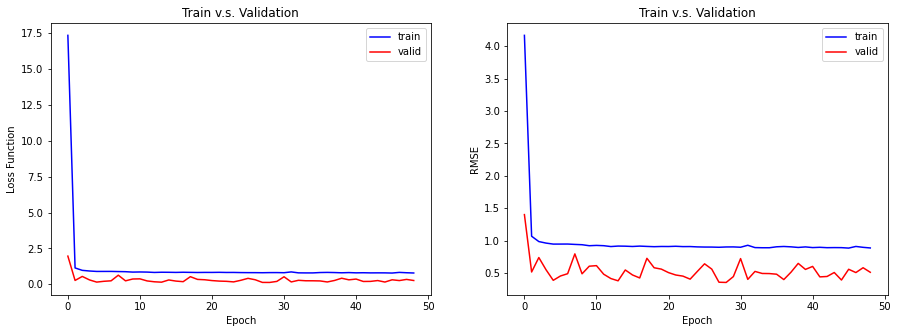

In [88]:
history(history_blstm24)

In [89]:
model_blstm_24.load_weights('weights_compare_blstm24.hdf5')
train_score_blstm_24 = model_blstm_24.evaluate(X_train, y_train, batch_size=32)
print('Train Loss: ', train_score_blstm_24[0])
print('Train RMSE: ', train_score_blstm_24[1])

98/98 [==============================] - 1s 7ms/step - loss: 0.6653 - root_mean_squared_error: 0.8156
Train Loss:  0.6652821898460388
Train RMSE:  0.8156483173370361


In [90]:
score_blstm_24 = model_blstm_24.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score_blstm_24[0])
print('Test RMSE: ', score_blstm_24[1])

2/2 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
Test Loss:  0.2053832709789276
Test RMSE:  0.4531923234462738


In [91]:
y_pred = model_blstm_24.predict(X_test)

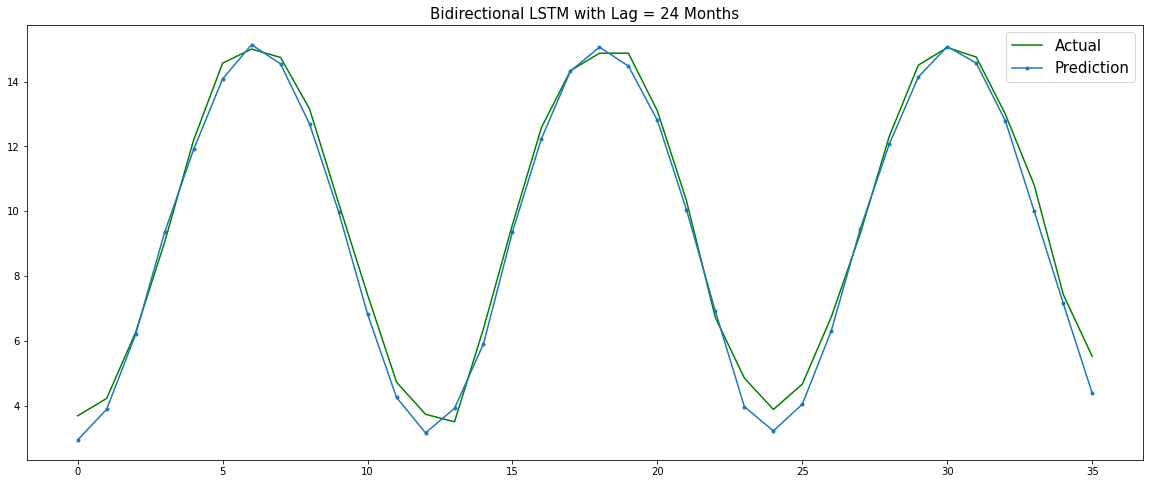

In [92]:
plt.figure(figsize=(20,8))
plt.plot(y_test, 'g', label='Actual')
plt.plot(y_pred, marker='.', label='Prediction')
plt.title('Bidirectional LSTM with Lag = 24 Months', size=15)
plt.legend(fontsize=15)
plt.show()

In [95]:
models = ['Single Layer LSTM with lag = 3 months', 'Bidirectional LSTM with lag = 3 months', \
         'Single Layer LSTM with lag = 12 months', 'Bidirectional LSTM with lag = 12 months', \
          'Bidirectional LSTM with lag = 24 months']
global_train = [train_score_lstm_3, train_score_blstm_3, train_score_lstm_12, train_score_blstm_12,\
                train_score_blstm_24]
global_test = [score_lstm_3, score_blstm_3, score_lstm_12, score_blstm_12, score_blstm_24]
global_train_df = pd.DataFrame(global_train, index=models, columns=['Train Loss', 'Train RMSE'])
global_test_df = pd.DataFrame(global_test, index=models, columns=['Test Loss', 'Test RMSE'])
global_df = pd.concat([global_train_df, global_test_df], axis=1)
global_df

Train Loss  Train RMSE  Test Loss  \
Single Layer LSTM with lag = 3 months      0.933769    0.966317   0.418949   
Bidirectional LSTM with lag = 3 months     1.066366    1.032650   0.287019   
Single Layer LSTM with lag = 12 months     0.678803    0.823895   0.393468   
Bidirectional LSTM with lag = 12 months    0.646572    0.804097   0.215673   
Bidirectional LSTM with lag = 24 months    0.665282    0.815648   0.205383   

                                         Test RMSE  
Single Layer LSTM with lag = 3 months     0.647263  
Bidirectional LSTM with lag = 3 months    0.535741  
Single Layer LSTM with lag = 12 months    0.627270  
Bidirectional LSTM with lag = 12 months   0.464406  
Bidirectional LSTM with lag = 24 months   0.453192

## Major City Comparison

In [57]:
def ts_plot(name):
    df = pd.read_csv(f'major_city/{name}.csv', header=None)
    df.rename(columns={0:'Index', 1:'LandAverageTemperature'}, inplace=True)
    df['Index'] = pd.to_datetime(df['Index'])
    df.sort_values(by='Index', inplace=True)
    plt.figure(figsize=(20,8))
    sns.lineplot(x='Index', y='LandAverageTemperature', color='g', data=df)
    plt.title(name, size=15)

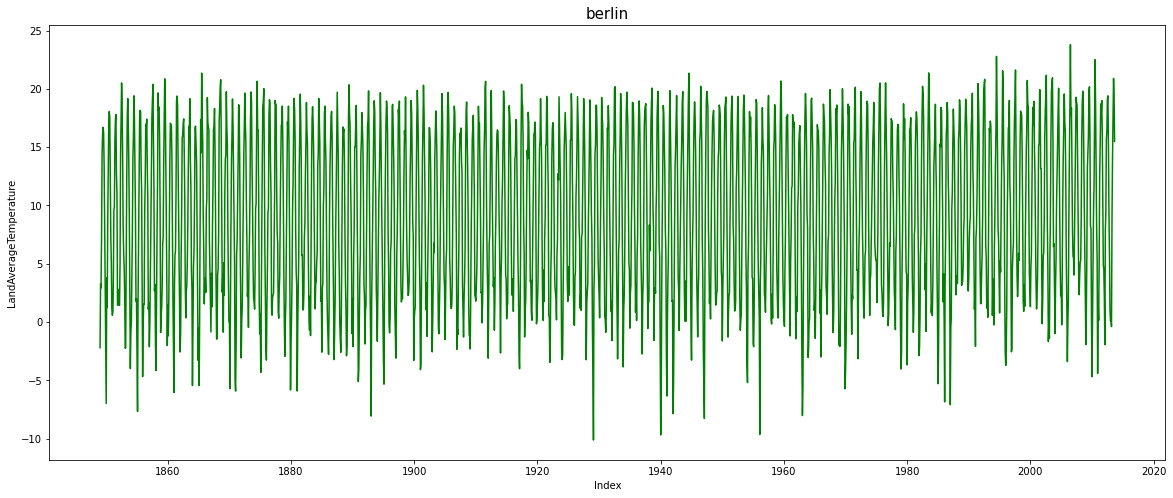

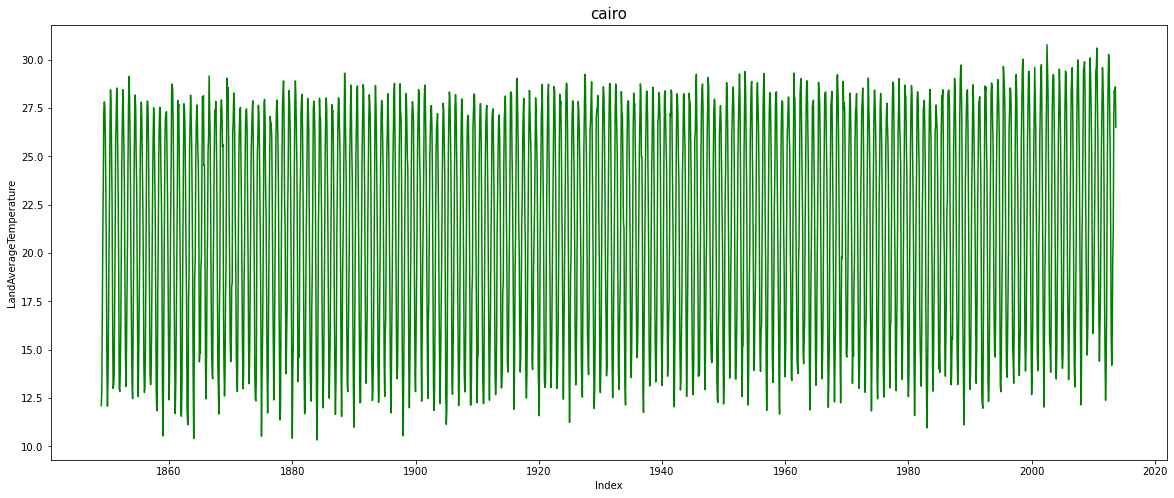

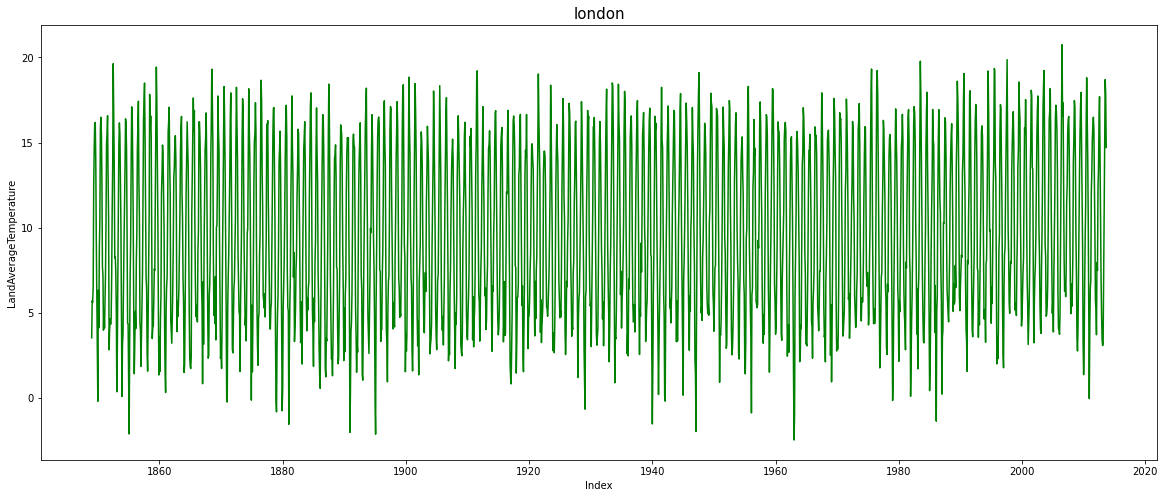

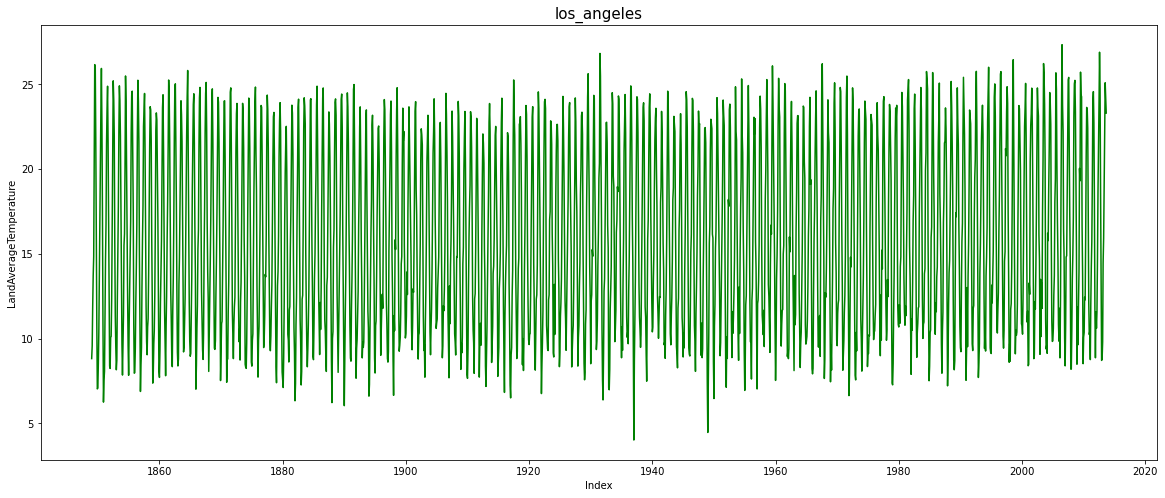

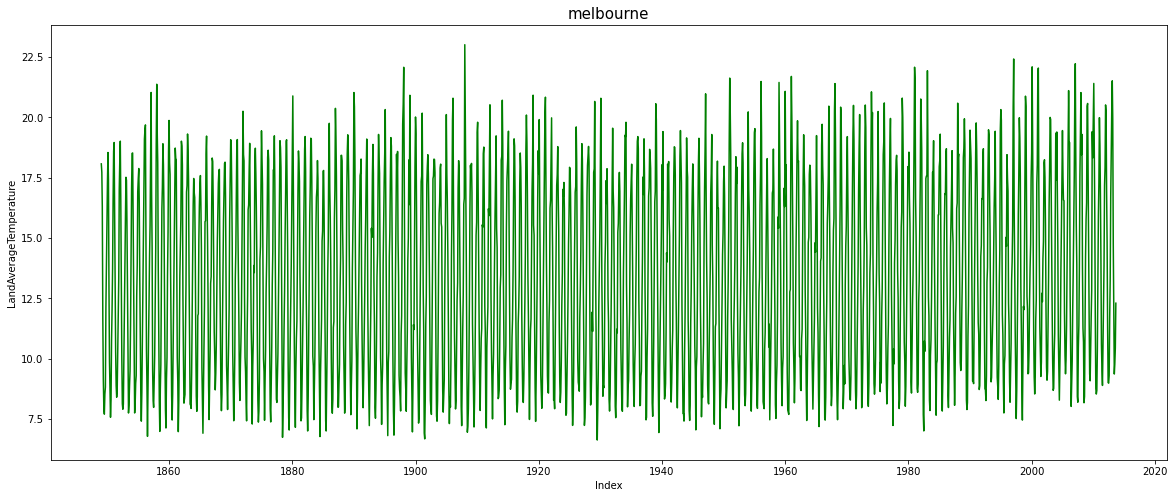

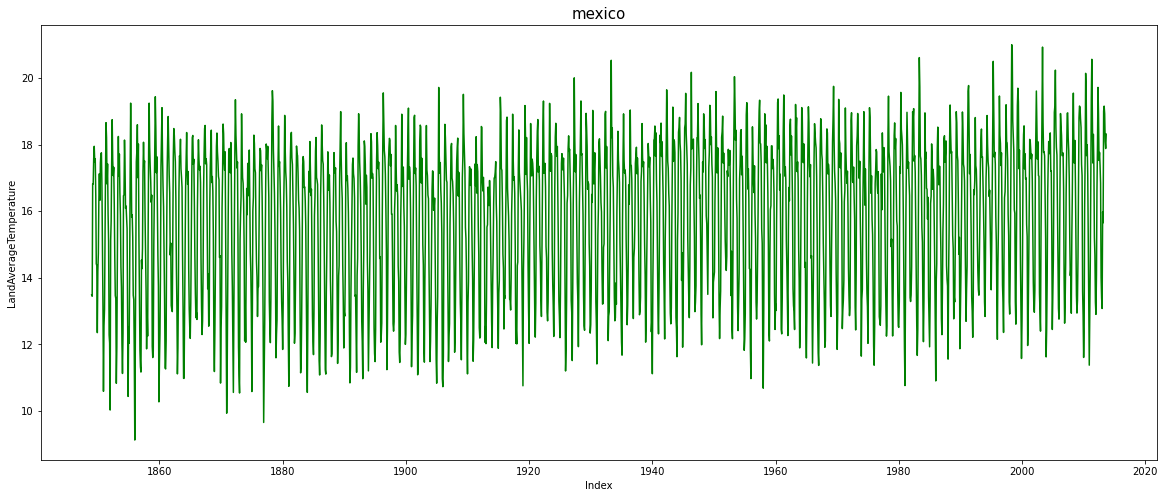

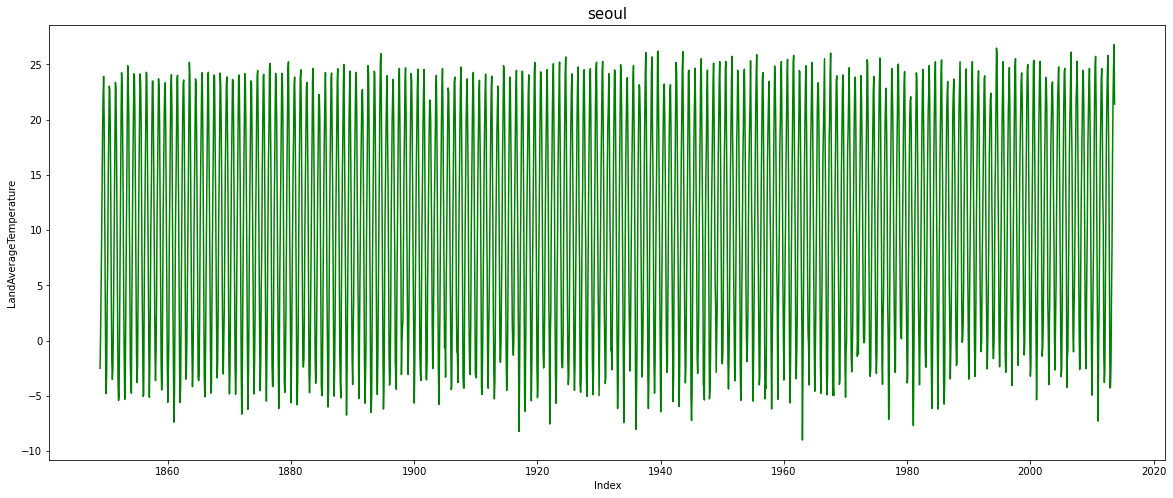

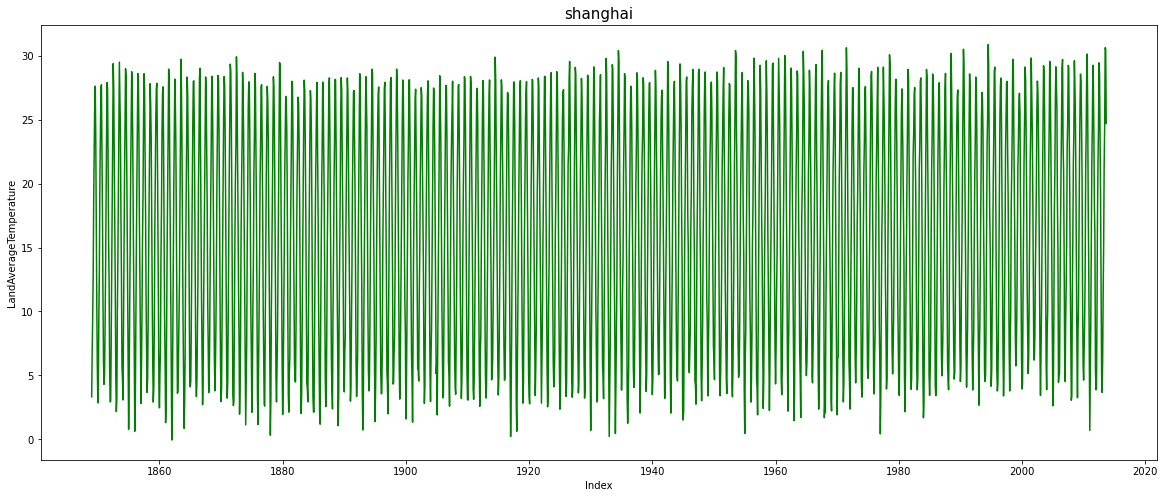

In [58]:
city = ['berlin', 'cairo', 'london', 'los_angeles', 'melbourne', 'mexico', 'seoul', 'shanghai']
for i in city:
    ts_plot(i)

In [93]:
lag = 12
test_period = 36
def city_model(name):
    df = pd.read_csv(f'major_city/{name}.csv', header=None)
    df.rename(columns={0:'Index', 1:'LandAverageTemperature'}, inplace=True)
    df['Index'] = pd.to_datetime(df['Index'])
    df.sort_values(by='Index', inplace=True)
    X_train, X_test, y_train, y_test = create_data_for_NN(df, df.columns[-1], lag, test_period)
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, input_shape=X_train.shape[1:])))
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer='sgd', metrics=[keras.metrics.RootMeanSquaredError(), ])
    checkpointer = ModelCheckpoint(filepath=f'weights_compare_{name}.hdf5', save_best_only=True)
    checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
    history_city = model.fit(X_train, y_train, validation_split=0.25, epochs=1000, batch_size=32, \
                     callbacks=[checkpointer,checkimprovement])
    history(history_city, name)
    model.load_weights(f'weights_compare_{name}.hdf5')
    score = model.evaluate(X_test, y_test, batch_size=32)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(20,8))
    plt.plot(y_test, 'g', label='Actual')
    plt.plot(y_pred, marker='.', label='Prediction')
    plt.title(name, size=15)
    plt.legend(fontsize=15)
    plt.show()
    print('Test Loss: ', score[0])
    print('Test RMSE: ', score[1])
    return score

Epoch 1/1000
46/46 [==============================] - 2s 16ms/step - loss: 17.8420 - root_mean_squared_error: 4.2240 - val_loss: 5.1624 - val_root_mean_squared_error: 2.2721
Epoch 2/1000
46/46 [==============================] - 0s 10ms/step - loss: 5.0930 - root_mean_squared_error: 2.2568 - val_loss: 6.3962 - val_root_mean_squared_error: 2.5291
Epoch 3/1000
46/46 [==============================] - 0s 10ms/step - loss: 5.1165 - root_mean_squared_error: 2.2620 - val_loss: 4.6705 - val_root_mean_squared_error: 2.1611
Epoch 4/1000
46/46 [==============================] - 0s 11ms/step - loss: 4.6578 - root_mean_squared_error: 2.1582 - val_loss: 4.3120 - val_root_mean_squared_error: 2.0765
Epoch 5/1000
46/46 [==============================] - 0s 10ms/step - loss: 4.6623 - root_mean_squared_error: 2.1592 - val_loss: 4.8714 - val_root_mean_squared_error: 2.2071
Epoch 6/1000
46/46 [==============================] - 0s 10ms/step - loss: 4.7714 - root_mean_squared_error: 2.1844 - val_loss: 4.1165

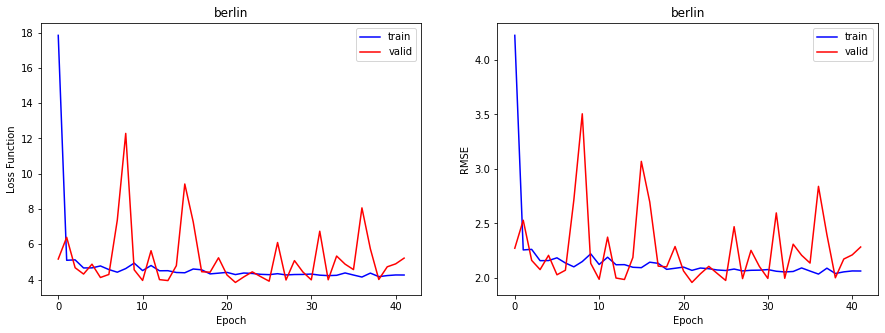

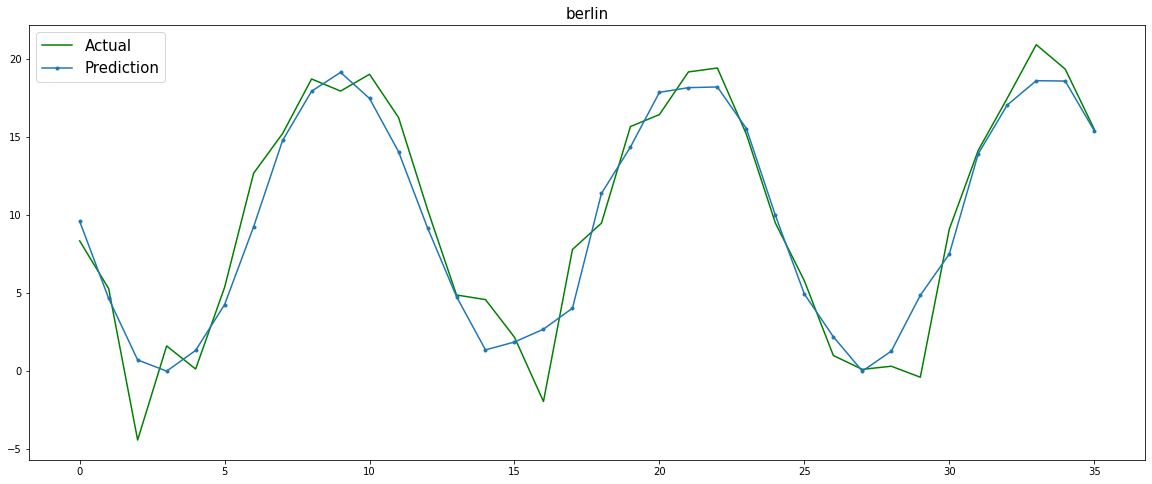

Test Loss:  4.2119269371032715
Test RMSE:  2.052298069000244


In [94]:
berlin_score = city_model('berlin')

Epoch 1/1000
46/46 [==============================] - 2s 13ms/step - loss: 42.6560 - root_mean_squared_error: 6.5312 - val_loss: 31.2572 - val_root_mean_squared_error: 5.5908
Epoch 2/1000
46/46 [==============================] - 0s 7ms/step - loss: 21.1754 - root_mean_squared_error: 4.6017 - val_loss: 20.2534 - val_root_mean_squared_error: 4.5004
Epoch 3/1000
46/46 [==============================] - 0s 8ms/step - loss: 14.7954 - root_mean_squared_error: 3.8465 - val_loss: 19.3388 - val_root_mean_squared_error: 4.3976
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 11.1107 - root_mean_squared_error: 3.3333 - val_loss: 12.3443 - val_root_mean_squared_error: 3.5134
Epoch 5/1000
46/46 [==============================] - 0s 9ms/step - loss: 12.8634 - root_mean_squared_error: 3.5866 - val_loss: 3.9930 - val_root_mean_squared_error: 1.9983
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 9.9381 - root_mean_squared_error: 3.1525 - val_loss: 7.5

46/46 [==============================] - 0s 7ms/step - loss: 3.8264 - root_mean_squared_error: 1.9561 - val_loss: 2.0196 - val_root_mean_squared_error: 1.4211
Epoch 49/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.6803 - root_mean_squared_error: 1.6371 - val_loss: 2.8580 - val_root_mean_squared_error: 1.6906
Epoch 50/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.9125 - root_mean_squared_error: 1.7066 - val_loss: 1.5576 - val_root_mean_squared_error: 1.2480
Epoch 51/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.1476 - root_mean_squared_error: 1.7742 - val_loss: 1.3244 - val_root_mean_squared_error: 1.1508
Epoch 52/1000
46/46 [==============================] - 0s 8ms/step - loss: 3.4520 - root_mean_squared_error: 1.8580 - val_loss: 10.8327 - val_root_mean_squared_error: 3.2913
Epoch 53/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.5957 - root_mean_squared_error: 1.8962 - val_loss: 3.3899 - val_root_me

46/46 [==============================] - 0s 8ms/step - loss: 1.4778 - root_mean_squared_error: 1.2157 - val_loss: 1.3531 - val_root_mean_squared_error: 1.1632
Epoch 96/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.4196 - root_mean_squared_error: 1.1915 - val_loss: 2.1333 - val_root_mean_squared_error: 1.4606
Epoch 97/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.6893 - root_mean_squared_error: 1.2997 - val_loss: 5.5903 - val_root_mean_squared_error: 2.3644
Epoch 98/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.5255 - root_mean_squared_error: 1.5892 - val_loss: 1.4398 - val_root_mean_squared_error: 1.1999
Epoch 99/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.6209 - root_mean_squared_error: 1.2731 - val_loss: 1.5346 - val_root_mean_squared_error: 1.2388
Epoch 100/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.9367 - root_mean_squared_error: 1.3917 - val_loss: 1.4721 - val_root_me

46/46 [==============================] - 0s 7ms/step - loss: 1.4345 - root_mean_squared_error: 1.1977 - val_loss: 1.3987 - val_root_mean_squared_error: 1.1827
Epoch 143/1000
2/2 [==============================] - 0s 1ms/step - loss: 1.7305 - root_mean_squared_error: 1.3155


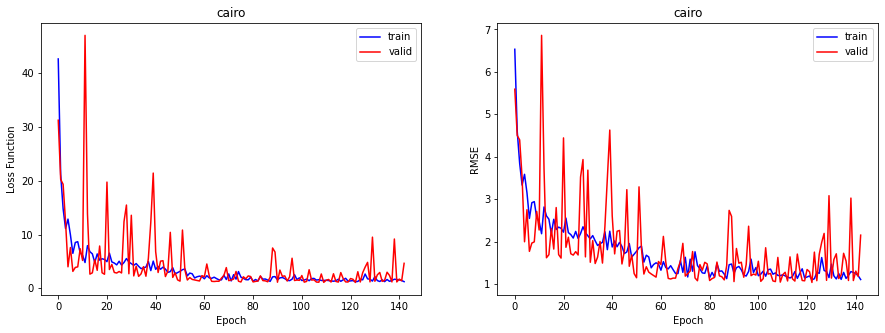

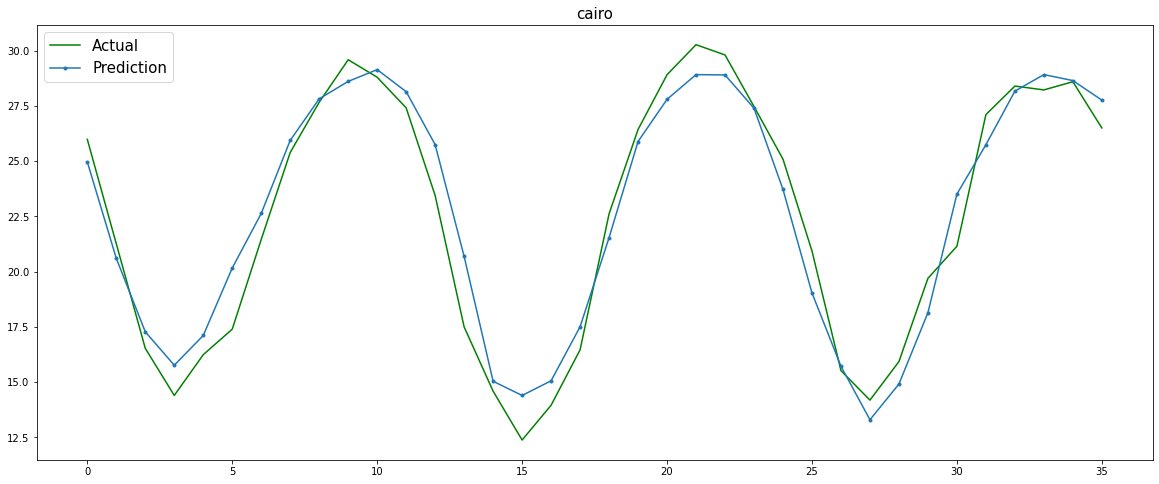

Test Loss:  1.7305207252502441
Test RMSE:  1.3154926300048828


In [96]:
cairo_score = city_model('cairo')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 10.8838 - root_mean_squared_error: 3.2991 - val_loss: 14.3685 - val_root_mean_squared_error: 3.7906
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8213 - root_mean_squared_error: 1.9548 - val_loss: 2.1337 - val_root_mean_squared_error: 1.4607
Epoch 3/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.4390 - root_mean_squared_error: 1.8545 - val_loss: 2.5502 - val_root_mean_squared_error: 1.5969
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.7304 - root_mean_squared_error: 1.6524 - val_loss: 2.3781 - val_root_mean_squared_error: 1.5421
Epoch 5/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.8847 - root_mean_squared_error: 1.6985 - val_loss: 2.6453 - val_root_mean_squared_error: 1.6264
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.6240 - root_mean_squared_error: 1.6199 - val_loss: 3.5739 - v

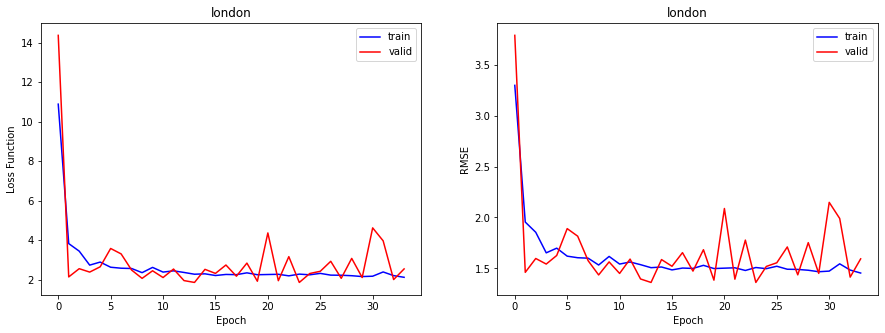

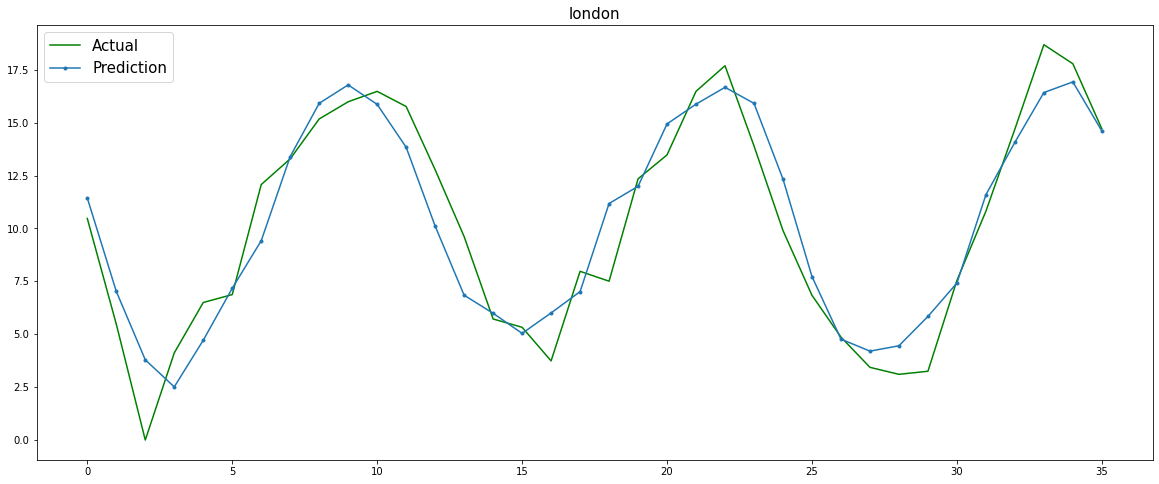

Test Loss:  2.808924674987793
Test RMSE:  1.6759847402572632


In [109]:
london_score = city_model('london')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 26.4553 - root_mean_squared_error: 5.1435 - val_loss: 11.2391 - val_root_mean_squared_error: 3.3525
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 14.9661 - root_mean_squared_error: 3.8686 - val_loss: 14.5435 - val_root_mean_squared_error: 3.8136
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 9.1032 - root_mean_squared_error: 3.0171 - val_loss: 5.1440 - val_root_mean_squared_error: 2.2680
Epoch 4/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.8403 - root_mean_squared_error: 2.4167 - val_loss: 4.4481 - val_root_mean_squared_error: 2.1091
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 6.2910 - root_mean_squared_error: 2.5082 - val_loss: 10.5143 - val_root_mean_squared_error: 3.2426
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 6.6762 - root_mean_squared_error: 2.5838 - val_loss: 5.5831 

46/46 [==============================] - 0s 7ms/step - loss: 2.1536 - root_mean_squared_error: 1.4675 - val_loss: 2.7499 - val_root_mean_squared_error: 1.6583
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.9663 - root_mean_squared_error: 1.4022 - val_loss: 2.8313 - val_root_mean_squared_error: 1.6827
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.3283 - root_mean_squared_error: 1.5259 - val_loss: 3.5379 - val_root_mean_squared_error: 1.8809
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.9578 - root_mean_squared_error: 1.3992 - val_loss: 3.0967 - val_root_mean_squared_error: 1.7597
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.0087 - root_mean_squared_error: 1.4173 - val_loss: 2.8634 - val_root_mean_squared_error: 1.6922
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.3118 - root_mean_squared_error: 1.5204 - val_loss: 2.5101 - val_root_mea

46/46 [==============================] - 0s 6ms/step - loss: 1.6140 - root_mean_squared_error: 1.2704 - val_loss: 3.8441 - val_root_mean_squared_error: 1.9606
Epoch 96/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.7376 - root_mean_squared_error: 1.3182 - val_loss: 2.7133 - val_root_mean_squared_error: 1.6472
Epoch 97/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.8675 - root_mean_squared_error: 1.3666 - val_loss: 2.3221 - val_root_mean_squared_error: 1.5238
Epoch 98/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.6099 - root_mean_squared_error: 1.2688 - val_loss: 2.4992 - val_root_mean_squared_error: 1.5809
Epoch 99/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.6054 - root_mean_squared_error: 1.2670 - val_loss: 3.5388 - val_root_mean_squared_error: 1.8812
Epoch 100/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5888 - root_mean_squared_error: 1.2605 - val_loss: 4.2817 - val_root_me

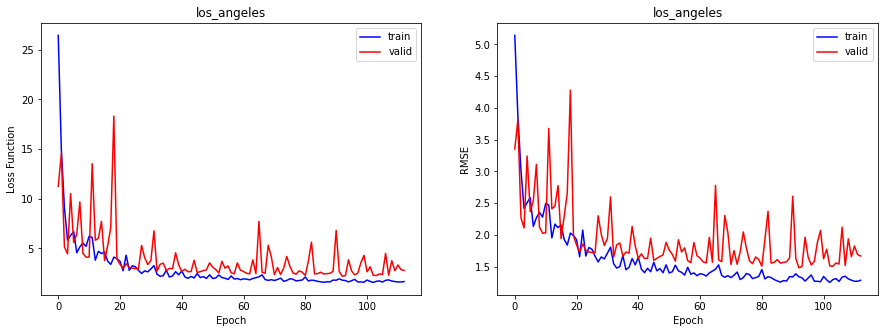

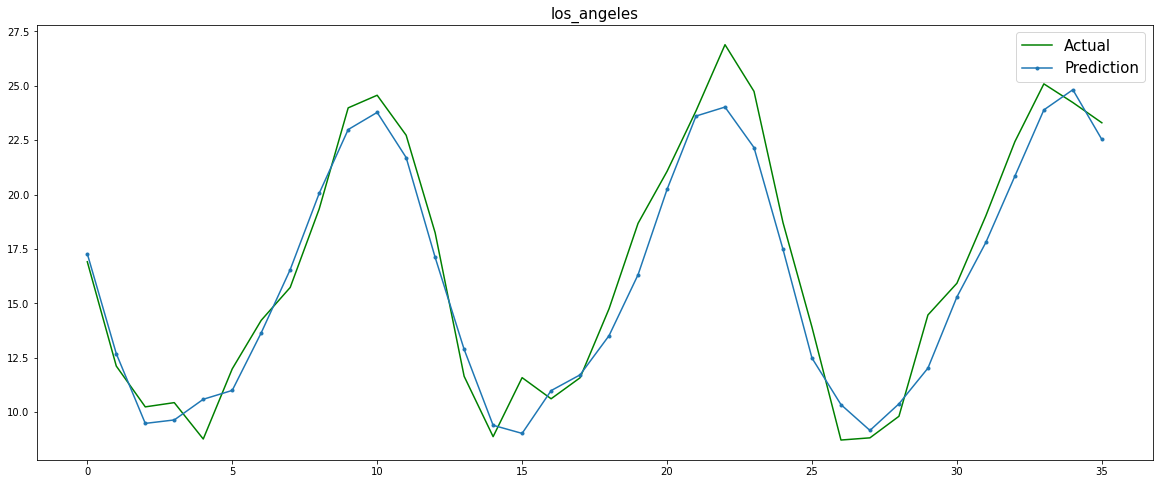

Test Loss:  1.726149082183838
Test RMSE:  1.3138298988342285


In [103]:
los_angeles_score = city_model('los_angeles')

Epoch 1/1000
46/46 [==============================] - 2s 13ms/step - loss: 13.7880 - root_mean_squared_error: 3.7132 - val_loss: 3.8217 - val_root_mean_squared_error: 1.9549
Epoch 2/1000
46/46 [==============================] - 0s 7ms/step - loss: 6.5997 - root_mean_squared_error: 2.5690 - val_loss: 3.4158 - val_root_mean_squared_error: 1.8482
Epoch 3/1000
46/46 [==============================] - 0s 7ms/step - loss: 3.3389 - root_mean_squared_error: 1.8273 - val_loss: 2.2856 - val_root_mean_squared_error: 1.5118
Epoch 4/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.2860 - root_mean_squared_error: 1.5119 - val_loss: 3.5477 - val_root_mean_squared_error: 1.8835
Epoch 5/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.7467 - root_mean_squared_error: 1.6573 - val_loss: 1.7703 - val_root_mean_squared_error: 1.3305
Epoch 6/1000
46/46 [==============================] - 0s 7ms/step - loss: 2.0243 - root_mean_squared_error: 1.4228 - val_loss: 4.8929 - va

46/46 [==============================] - 0s 8ms/step - loss: 1.0418 - root_mean_squared_error: 1.0207 - val_loss: 2.0836 - val_root_mean_squared_error: 1.4435
Epoch 49/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.0124 - root_mean_squared_error: 1.0062 - val_loss: 1.4807 - val_root_mean_squared_error: 1.2168
Epoch 50/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.0312 - root_mean_squared_error: 1.0155 - val_loss: 2.2550 - val_root_mean_squared_error: 1.5017
Epoch 51/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.0295 - root_mean_squared_error: 1.0146 - val_loss: 2.1574 - val_root_mean_squared_error: 1.4688
Epoch 52/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.1557 - root_mean_squared_error: 1.0750 - val_loss: 1.7277 - val_root_mean_squared_error: 1.3144
Epoch 53/1000
46/46 [==============================] - 0s 7ms/step - loss: 1.1129 - root_mean_squared_error: 1.0550 - val_loss: 1.6851 - val_root_mea

46/46 [==============================] - 0s 7ms/step - loss: 0.9716 - root_mean_squared_error: 0.9857 - val_loss: 1.2138 - val_root_mean_squared_error: 1.1017
Epoch 96/1000
46/46 [==============================] - 0s 7ms/step - loss: 0.9752 - root_mean_squared_error: 0.9875 - val_loss: 1.2179 - val_root_mean_squared_error: 1.1036
Epoch 97/1000
46/46 [==============================] - 0s 7ms/step - loss: 0.9336 - root_mean_squared_error: 0.9662 - val_loss: 2.5891 - val_root_mean_squared_error: 1.6091
Epoch 98/1000
46/46 [==============================] - 0s 8ms/step - loss: 1.0008 - root_mean_squared_error: 1.0004 - val_loss: 1.3723 - val_root_mean_squared_error: 1.1714
Epoch 99/1000
46/46 [==============================] - 0s 7ms/step - loss: 0.9352 - root_mean_squared_error: 0.9670 - val_loss: 1.3041 - val_root_mean_squared_error: 1.1420
Epoch 100/1000
46/46 [==============================] - 0s 7ms/step - loss: 0.9293 - root_mean_squared_error: 0.9640 - val_loss: 1.1825 - val_root_me

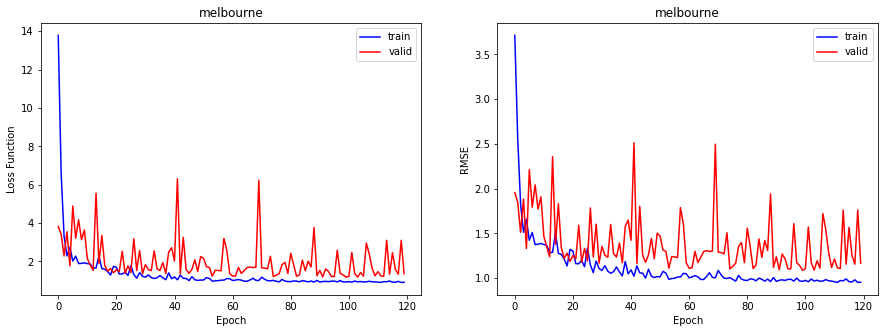

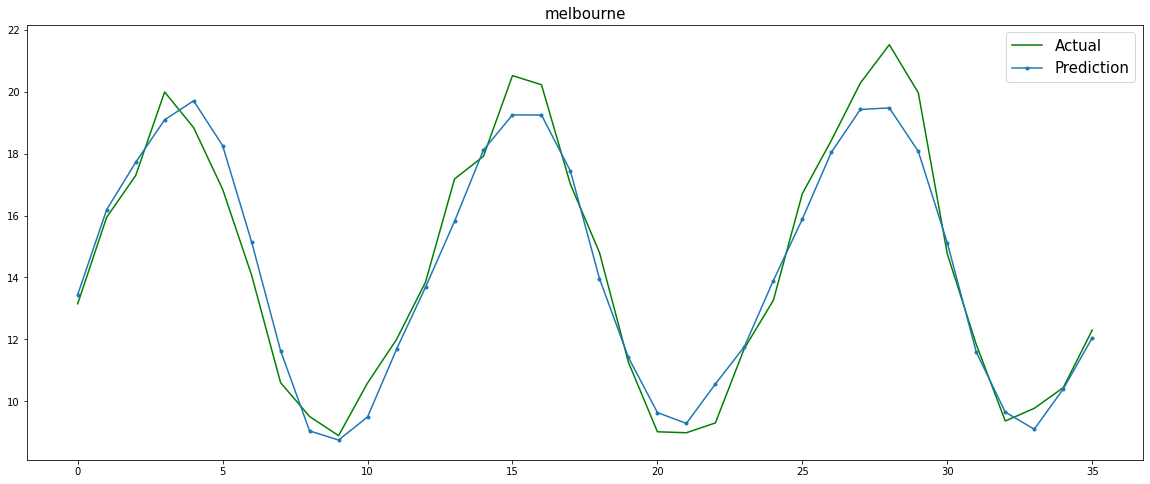

Test Loss:  0.711184561252594
Test RMSE:  0.8433175683021545


In [99]:
melbourne_score = city_model('melbourne')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 10.1021 - root_mean_squared_error: 3.1784 - val_loss: 6.1918 - val_root_mean_squared_error: 2.4883
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.7624 - root_mean_squared_error: 2.1823 - val_loss: 2.5866 - val_root_mean_squared_error: 1.6083
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8065 - root_mean_squared_error: 1.9510 - val_loss: 6.3361 - val_root_mean_squared_error: 2.5172
Epoch 4/1000
46/46 [==============================] - 0s 6ms/step - loss: 2.8285 - root_mean_squared_error: 1.6818 - val_loss: 4.4883 - val_root_mean_squared_error: 2.1186
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.1246 - root_mean_squared_error: 1.7677 - val_loss: 2.3150 - val_root_mean_squared_error: 1.5215
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.6999 - root_mean_squared_error: 1.9235 - val_loss: 1.3919 - va

46/46 [==============================] - 0s 6ms/step - loss: 1.1713 - root_mean_squared_error: 1.0823 - val_loss: 1.2510 - val_root_mean_squared_error: 1.1185
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.9884 - root_mean_squared_error: 0.9942 - val_loss: 1.9514 - val_root_mean_squared_error: 1.3969
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7959 - root_mean_squared_error: 0.8922 - val_loss: 0.7929 - val_root_mean_squared_error: 0.8905
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7996 - root_mean_squared_error: 0.8942 - val_loss: 0.7476 - val_root_mean_squared_error: 0.8646
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.2616 - root_mean_squared_error: 1.1232 - val_loss: 0.7455 - val_root_mean_squared_error: 0.8634
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.9261 - root_mean_squared_error: 0.9623 - val_loss: 1.4524 - val_root_mea

46/46 [==============================] - 0s 7ms/step - loss: 0.9068 - root_mean_squared_error: 0.9523 - val_loss: 1.5725 - val_root_mean_squared_error: 1.2540
Epoch 96/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.8573 - root_mean_squared_error: 0.9259 - val_loss: 0.7217 - val_root_mean_squared_error: 0.8495
Epoch 97/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.8341 - root_mean_squared_error: 0.9133 - val_loss: 2.9305 - val_root_mean_squared_error: 1.7119
Epoch 98/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.0830 - root_mean_squared_error: 1.0407 - val_loss: 0.7062 - val_root_mean_squared_error: 0.8404
Epoch 99/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.8766 - root_mean_squared_error: 0.9363 - val_loss: 0.9042 - val_root_mean_squared_error: 0.9509
Epoch 100/1000
46/46 [==============================] - 0s 7ms/step - loss: 0.8092 - root_mean_squared_error: 0.8995 - val_loss: 0.9472 - val_root_me

46/46 [==============================] - 0s 6ms/step - loss: 0.7030 - root_mean_squared_error: 0.8384 - val_loss: 0.8862 - val_root_mean_squared_error: 0.9414
Epoch 143/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7258 - root_mean_squared_error: 0.8520 - val_loss: 0.7562 - val_root_mean_squared_error: 0.8696
Epoch 144/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7139 - root_mean_squared_error: 0.8449 - val_loss: 1.0954 - val_root_mean_squared_error: 1.0466
Epoch 145/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7792 - root_mean_squared_error: 0.8827 - val_loss: 0.6559 - val_root_mean_squared_error: 0.8099
Epoch 146/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7477 - root_mean_squared_error: 0.8647 - val_loss: 0.9882 - val_root_mean_squared_error: 0.9941
Epoch 147/1000
46/46 [==============================] - 0s 6ms/step - loss: 0.7192 - root_mean_squared_error: 0.8481 - val_loss: 0.8264 - val_roo

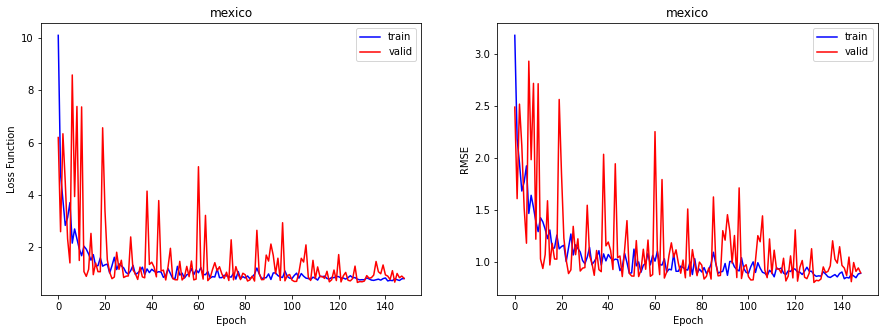

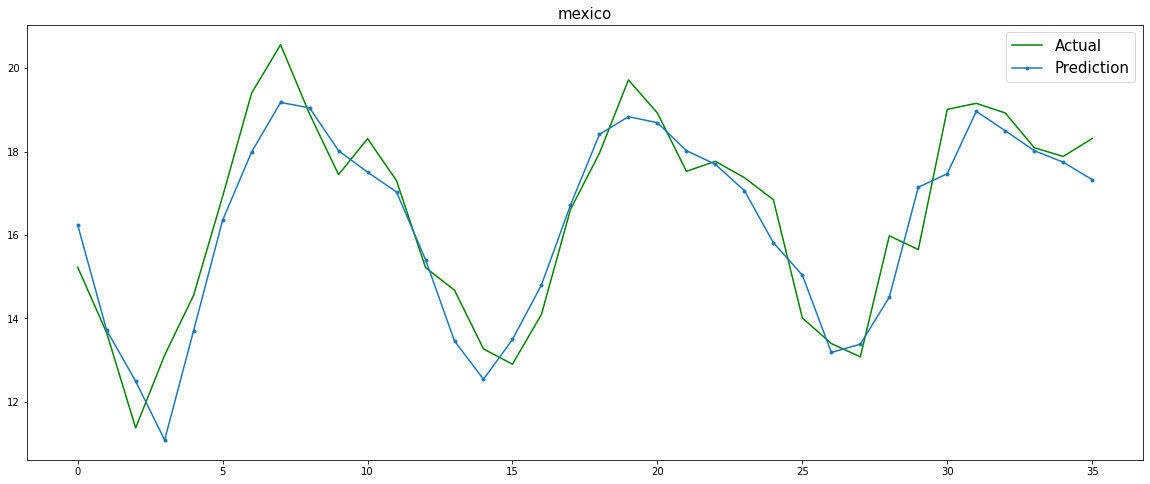

Test Loss:  0.7488159537315369
Test RMSE:  0.8653415441513062


In [106]:
mexico_score = city_model('mexico')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 15.4775 - root_mean_squared_error: 3.9341 - val_loss: 4.2083 - val_root_mean_squared_error: 2.0514
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.7302 - root_mean_squared_error: 2.1749 - val_loss: 9.7737 - val_root_mean_squared_error: 3.1263
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 5.1679 - root_mean_squared_error: 2.2733 - val_loss: 4.2005 - val_root_mean_squared_error: 2.0495
Epoch 4/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.4474 - root_mean_squared_error: 2.1089 - val_loss: 4.3172 - val_root_mean_squared_error: 2.0778
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.4482 - root_mean_squared_error: 2.1091 - val_loss: 3.1171 - val_root_mean_squared_error: 1.7655
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 4.1559 - root_mean_squared_error: 2.0386 - val_loss: 2.7999 - va

46/46 [==============================] - 0s 6ms/step - loss: 3.8307 - root_mean_squared_error: 1.9572 - val_loss: 2.7105 - val_root_mean_squared_error: 1.6464
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8168 - root_mean_squared_error: 1.9537 - val_loss: 2.7603 - val_root_mean_squared_error: 1.6614
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8393 - root_mean_squared_error: 1.9594 - val_loss: 2.6135 - val_root_mean_squared_error: 1.6166
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8572 - root_mean_squared_error: 1.9640 - val_loss: 3.8560 - val_root_mean_squared_error: 1.9637
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8455 - root_mean_squared_error: 1.9610 - val_loss: 2.7001 - val_root_mean_squared_error: 1.6432
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 3.8707 - root_mean_squared_error: 1.9674 - val_loss: 4.5303 - val_root_mea

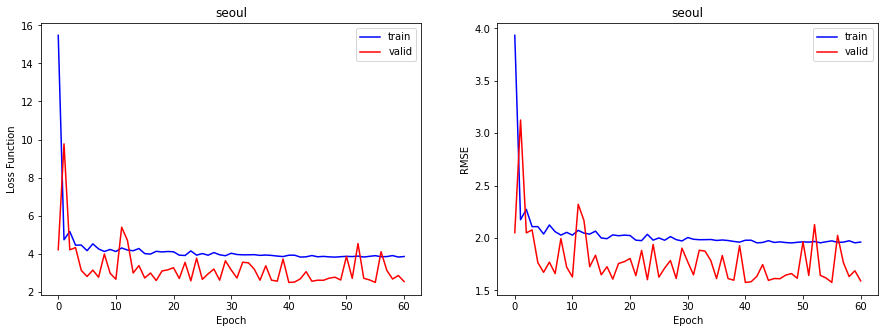

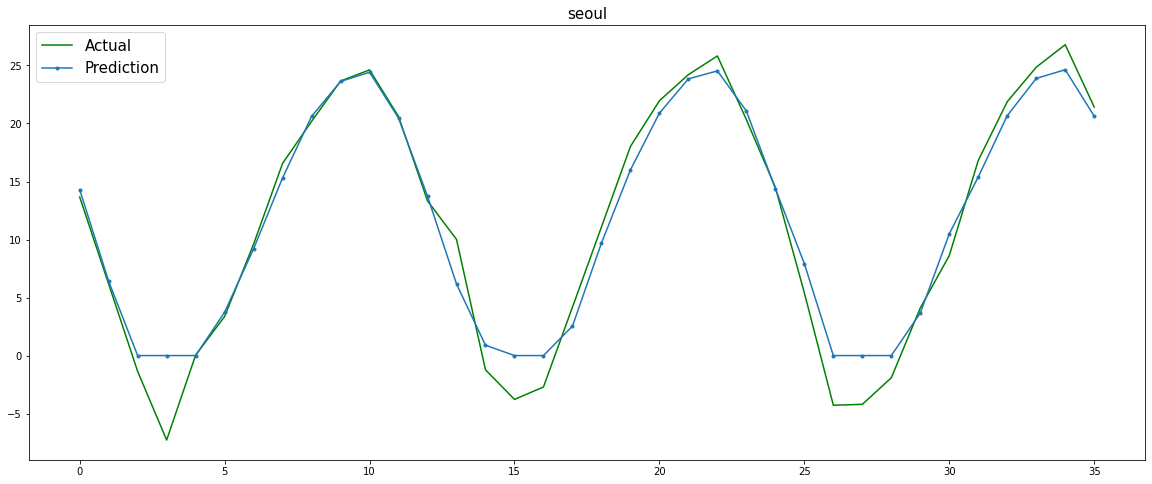

Test Loss:  4.721217155456543
Test RMSE:  2.1728363037109375


In [101]:
seoul_score = city_model('seoul')

Epoch 1/1000
46/46 [==============================] - 2s 12ms/step - loss: 34.3327 - root_mean_squared_error: 5.8594 - val_loss: 29.1478 - val_root_mean_squared_error: 5.3989
Epoch 2/1000
46/46 [==============================] - 0s 6ms/step - loss: 11.3055 - root_mean_squared_error: 3.3624 - val_loss: 29.7240 - val_root_mean_squared_error: 5.4520
Epoch 3/1000
46/46 [==============================] - 0s 6ms/step - loss: 11.2412 - root_mean_squared_error: 3.3528 - val_loss: 8.1978 - val_root_mean_squared_error: 2.8632
Epoch 4/1000
46/46 [==============================] - 0s 6ms/step - loss: 6.9082 - root_mean_squared_error: 2.6283 - val_loss: 6.5205 - val_root_mean_squared_error: 2.5535
Epoch 5/1000
46/46 [==============================] - 0s 6ms/step - loss: 6.3906 - root_mean_squared_error: 2.5280 - val_loss: 39.9569 - val_root_mean_squared_error: 6.3211
Epoch 6/1000
46/46 [==============================] - 0s 6ms/step - loss: 8.1841 - root_mean_squared_error: 2.8608 - val_loss: 2.7571

46/46 [==============================] - 0s 6ms/step - loss: 1.6677 - root_mean_squared_error: 1.2914 - val_loss: 4.7810 - val_root_mean_squared_error: 2.1866
Epoch 49/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5198 - root_mean_squared_error: 1.2328 - val_loss: 2.0295 - val_root_mean_squared_error: 1.4246
Epoch 50/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5428 - root_mean_squared_error: 1.2421 - val_loss: 2.6727 - val_root_mean_squared_error: 1.6348
Epoch 51/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.5248 - root_mean_squared_error: 1.2348 - val_loss: 1.6002 - val_root_mean_squared_error: 1.2650
Epoch 52/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.6630 - root_mean_squared_error: 1.2896 - val_loss: 4.4217 - val_root_mean_squared_error: 2.1028
Epoch 53/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.4398 - root_mean_squared_error: 1.1999 - val_loss: 1.6428 - val_root_mea

46/46 [==============================] - 0s 6ms/step - loss: 1.3405 - root_mean_squared_error: 1.1578 - val_loss: 2.6778 - val_root_mean_squared_error: 1.6364
Epoch 96/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.3299 - root_mean_squared_error: 1.1532 - val_loss: 1.8882 - val_root_mean_squared_error: 1.3741
Epoch 97/1000
46/46 [==============================] - 0s 6ms/step - loss: 1.2628 - root_mean_squared_error: 1.1237 - val_loss: 1.8467 - val_root_mean_squared_error: 1.3589
Epoch 98/1000
2/2 [==============================] - 0s 1ms/step - loss: 1.9228 - root_mean_squared_error: 1.3867


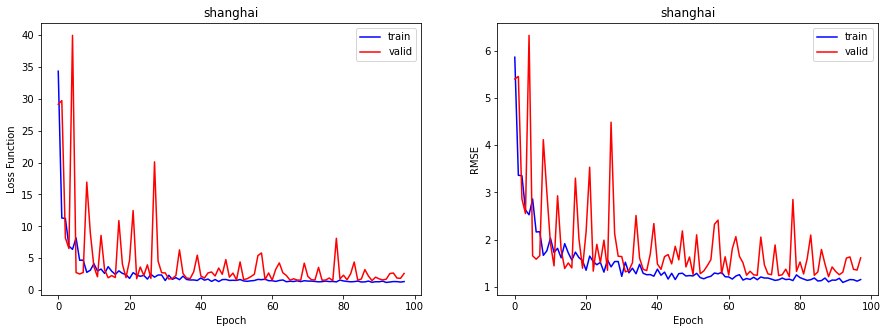

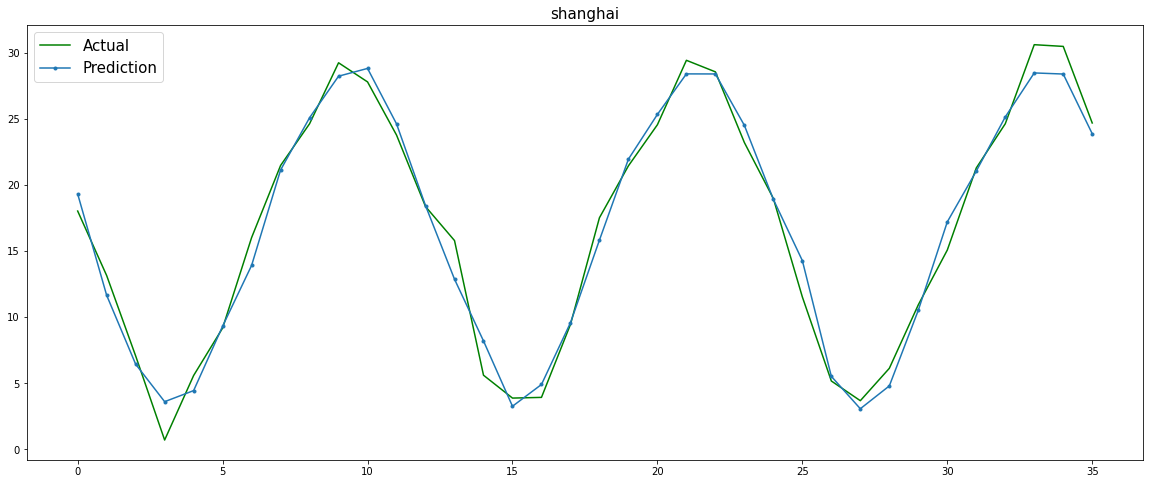

Test Loss:  1.9228401184082031
Test RMSE:  1.3866651058197021


In [102]:
shanghai_score = city_model('shanghai')

In [110]:
city_list = [berlin_score, cairo_score, london_score, los_angeles_score, \
            melbourne_score, mexico_score, seoul_score, shanghai_score]
city_df = pd.DataFrame(city_list, index=city, columns=['Loss', 'RMSE'])

In [111]:
city_df

Loss      RMSE
berlin       4.211927  2.052298
cairo        1.730521  1.315493
london       2.808925  1.675985
los_angeles  1.726149  1.313830
melbourne    0.711185  0.843318
mexico       0.748816  0.865342
seoul        4.721217  2.172836
shanghai     1.922840  1.386665

In [70]:
def ts_plot(name):
    df = pd.read_csv(f'major_city/{name}.csv', header=None)
    df.rename(columns={0:'Index', 1:'LandAverageTemperature'}, inplace=True)
    df['Index'] = pd.to_datetime(df['Index'])
    df.sort_values(by='Index', inplace=True)
    df = df[(df['Index'] >= '2008-01-01') & (df['Index'] <= '2013-12-01')]
    plt.figure(figsize=(20,8))
    sns.lineplot(x='Index', y='LandAverageTemperature', color='g', data=df)
    plt.title(name, size=15)

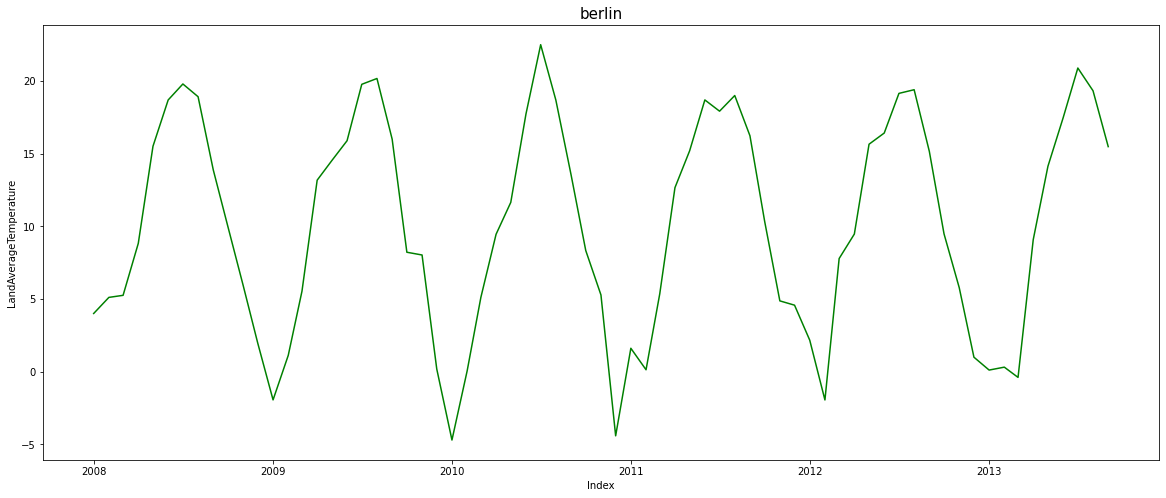

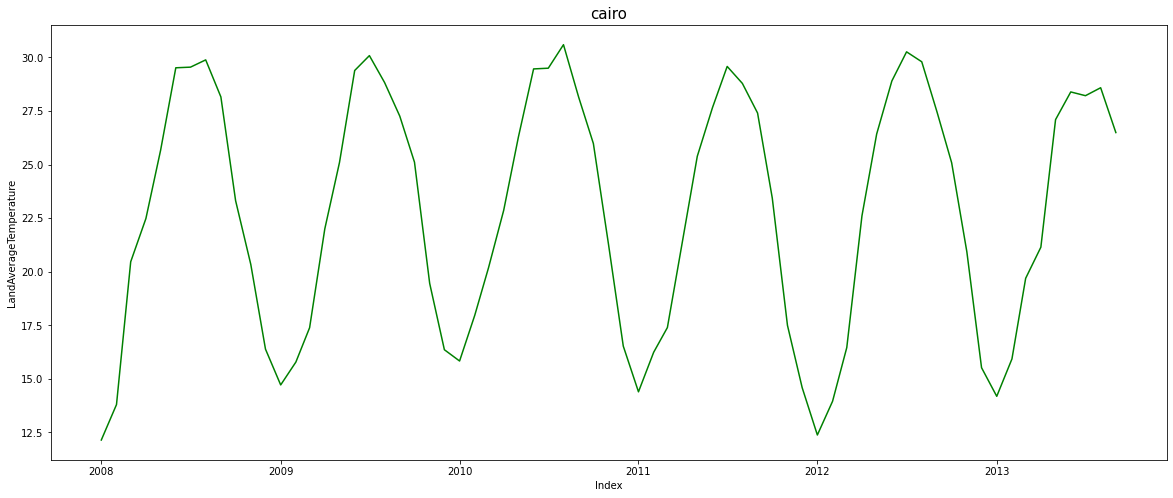

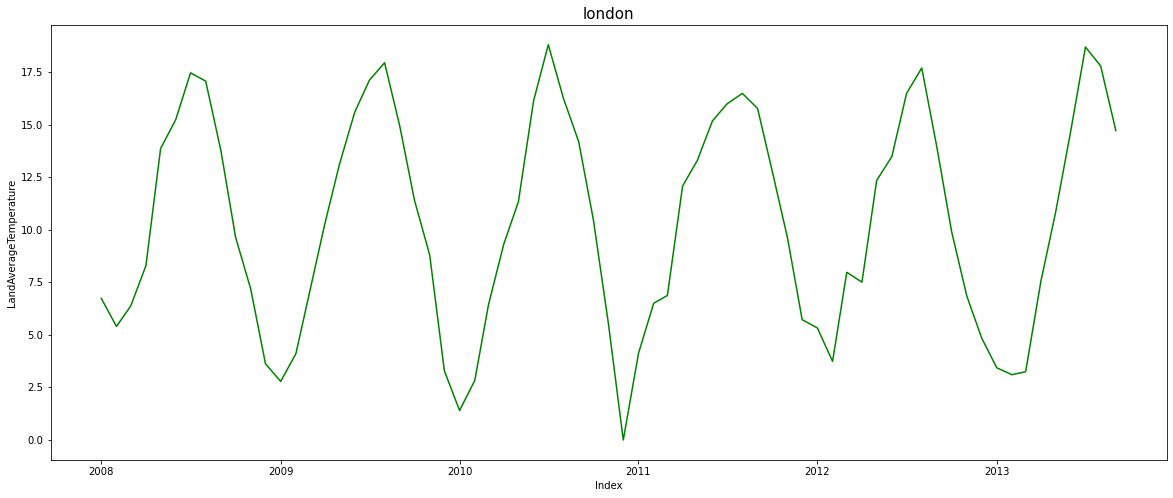

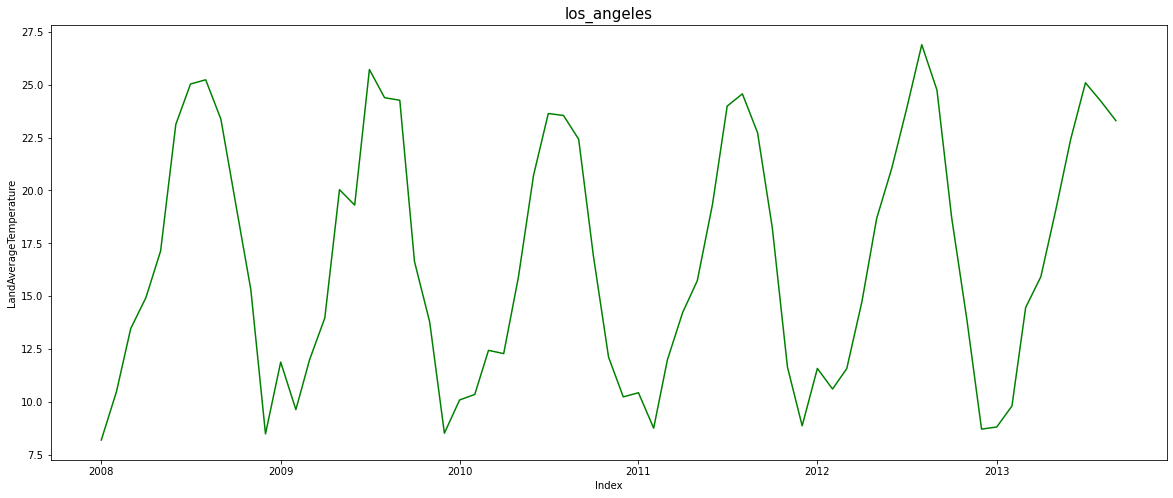

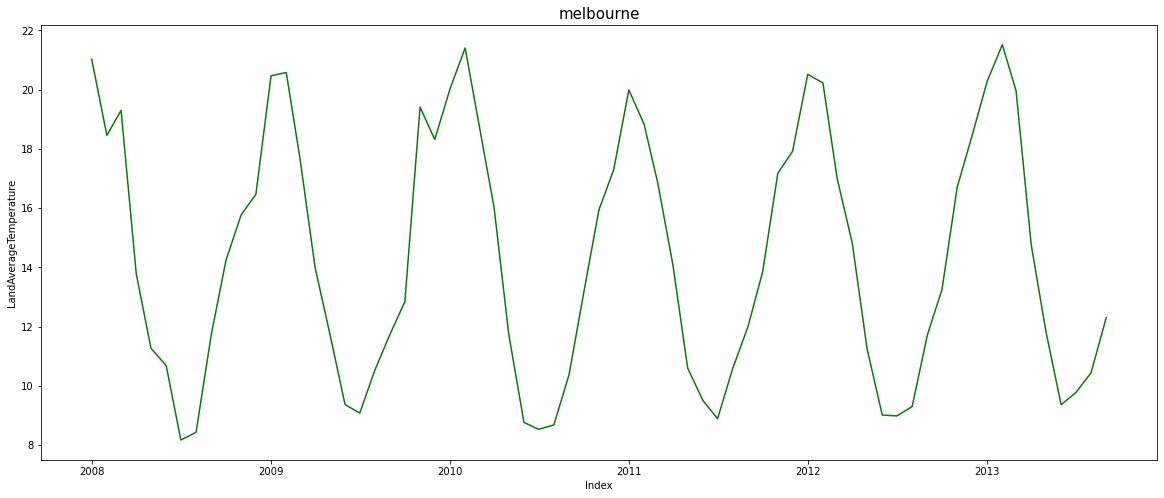

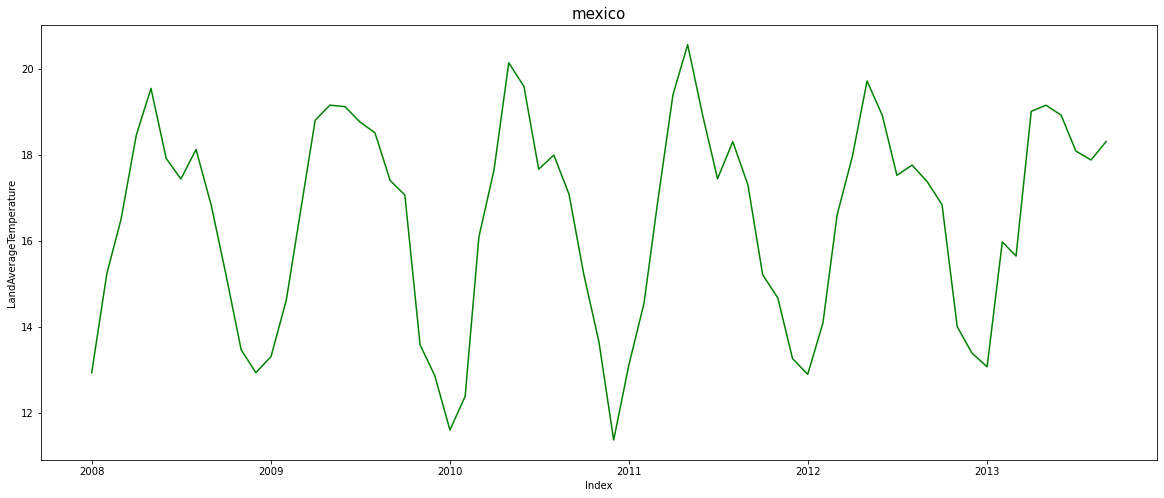

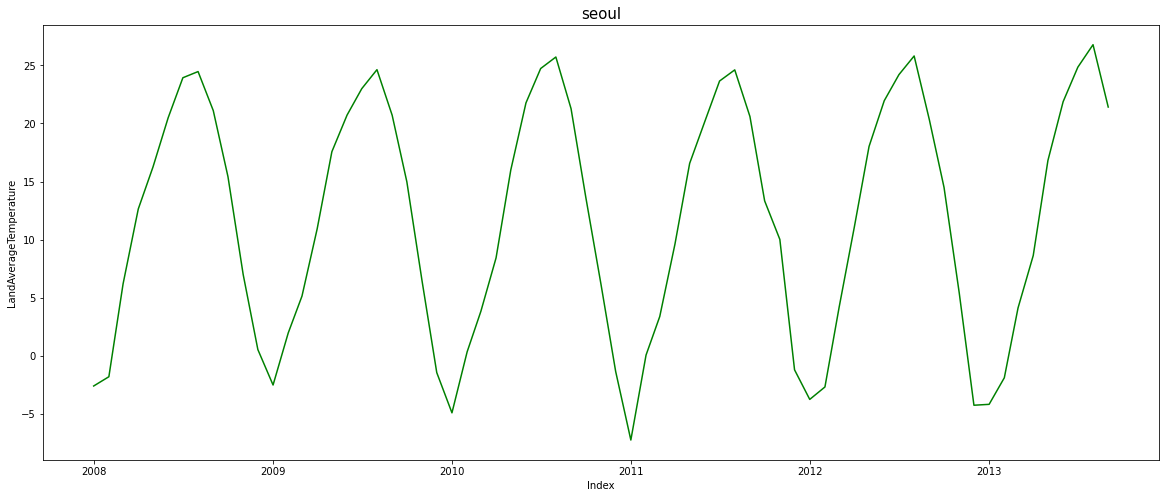

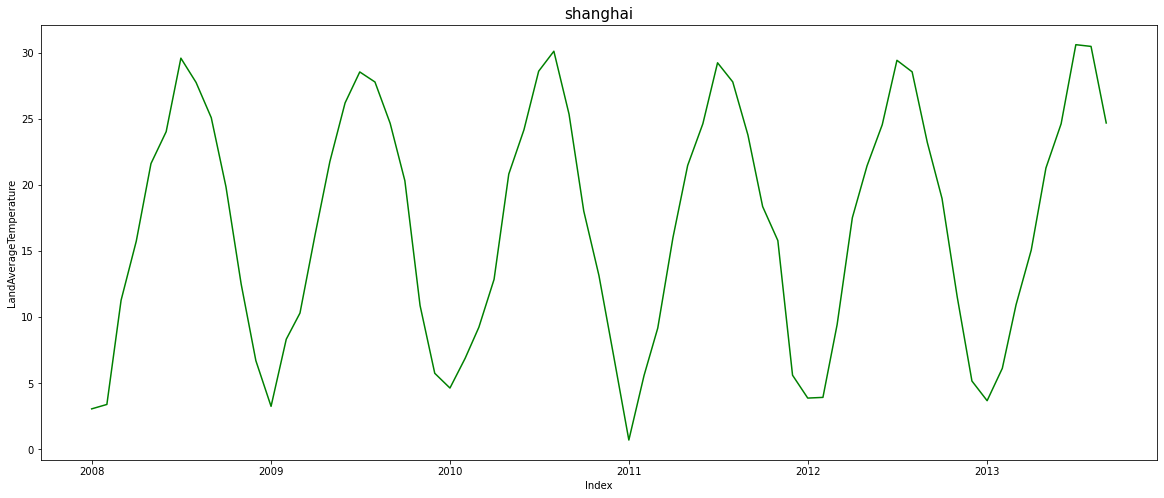

In [71]:
for i in city:
    ts_plot(i)